# The Sum-to-Zero Constraint in Stan

In [1]:
# libraries used in this notebook
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import plotnine as p9
import libpysal
from splot.libpysal import plot_spatial_weights 
from random import randint

from cmdstanpy import CmdStanModel, write_stan_json, cmdstan_path, cmdstan_version, rebuild_cmdstan

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# notebook display options
plt.rcParams['figure.figsize'] = (7, 7)
plt.rcParams['figure.dpi'] = 100

np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)
pd.set_option('display.precision', 2)
pd.options.display.float_format = '{:.2f}'.format


# helper functions

def extract_numeric_index(idx: pd.Index) -> pd.Series:
    return idx.str.extract(r'[a-z_]*\[(\d+)\]', expand=False).astype(int)

# Use inline row index tracking to add divider every 3rd row
from pandas.io.formats.style import Styler

def style_dataframe(df: pd.DataFrame) -> Styler:
    def highlight_every_3rd_row(row: pd.Series, row_index: int) -> list[str]:
        if (row_index + 1) % 3 == 0:  # Apply border every 3rd row
            return ['border-bottom: 3px double black'] * len(row)
        return [''] * len(row)
    return (df.style
              .apply(lambda row: highlight_every_3rd_row(row, df.index.get_loc(row.name)), axis=1)
              .format(precision=2)
           )


# Filter and sort predictors
def summarize_predictor(df: pd.DataFrame, name: str) -> pd.DataFrame:
    pred_summary = df.filter(regex=name, axis=0).sort_index()
    if "[" in name:
        pred_summary = pred_summary.sort_index(key=extract_numeric_index)
    
    return pred_summary[['Mean', 'StdDev', 'ESS_bulk', 'ESS_tail', 'R_hat']]


# side-by-side tables
from IPython.core.display import display, HTML
def display_side_by_side(
    html_left: str,
    html_right: str,
    title_left: str = "Small Dataset",
    title_right: str = "Large Dataset"
) -> None:
    """
    Displays two HTML tables side by side in a Jupyter Notebook.
    """
    html_code = f"""
    <div style="display: flex; justify-content: space-between; gap: 10px;">
        <div style="width: 48%; border: 1px solid #ddd; padding: 5px;">
            <b><i>{title_left}</i></b>
            {html_left}
        </div>
        <div style="width: 48%; border: 1px solid #ddd; padding: 5px;">
            <b><i>{title_right}</i></b>
            {html_right}
        </div>
    </div>
    """
    display(HTML(html_code))

## Introducing the `sum_to_zero_vector` Constrained Parameter Type

 
The [`sum_to_zero_vector`](https://mc-stan.org/docs/reference-manual/transforms.html#zero-sum-vector)
constrained parameter type was introduced in the [Stan 2.36 release](https://github.com/stan-dev/cmdstan/releases/tag/v2.36.0).

The parameter declaration:

```stan
  sum_to_zero_vector[K] beta;
```
produces a vector of size `K` such that `sum(beta) = 0`.
The unconstrained representation requires only `K - 1` values because the
last is determined by the first `K - 1`.

Further discussion is in [this post on the Stan Discourse forums](https://discourse.mc-stan.org/t/zero-sum-vector-and-normal-distribution/38296)

>A sum to zero vector is exactly what the name suggests. A vector where the sum of the elements equals 0.
If you put a normal prior on the zero-sum vector the resulting variance will be less than the intended normal variance.
To get the same variance as the intended normal prior do

```stan
parameters {
  sum_to_zero_vector[N] z;
}
model {
  z ~ normal(0, sqrt(N * inv(N - 1)) * sigma)
}
```
>where sigma is the intended standard deviation. FYI, it’s a bit more efficient to pre-calculate the `sqrt(N * inv(N - 1))` in transformed_data.
The general result to get a given variance from a normal with linear constraints is in: Fraser, D. A. S. (1951).
Normal Samples With Linear Constraints and Given Variances. Canadian Journal of Mathematics, 3, 363–366. [doi:10.4153/CJM-1951-041-9](https://doi.org/10.4153/CJM-1951-041-9).

Prior to Stan 2.36, a sum-to-zero constraint could be implemented in one of two ways:

- As a "hard" sum to zero constraint, where the parameter is declared to be an $N-1$ length vector with a corresponding $N$-length transformed parameter
whose first $N-1$ elements are the same as the corresponding parameter vector, and the $N^{th}$ element is the negative sum of the $N-1$ elements.


- As a "soft" sum to zero constraint with an $N$-length parameter vector whose sum is constrained to be within $\epsilon$ of $0$.

Up until now, users had to choose between the hard or soft sum-to-zero constraint, without clear guidance.
As a general rule, for small vectors, the hard sum-to-zero constraint is more efficient;
for larger vectors, the soft sum-to-zero constraint is faster,
but much depends on the specifics of the model and the data.


For small $N$ and models with sensible priors, the hard sum-to-zero is usually satisfactory.
But as the size of the vector grows, it distorts the marginal variance of the $N^{th}$.
Given a parameter vector:
$$
x_1, x_2, \dots, x_{N-1} \sim \text{i.i.d. } N(0, \sigma^2)
$$
by the properties of independent normal variables, each of the free elements $x_1, \ldots, x_{N-1}$ has variance $\sigma^2$.
However, the $N^{th}$ element is defined deterministically as:
$$
x_N = -\sum_{i=1}^{N-1} x_i
$$
and its variance is inflated by a factor of $N-1$.
$$
\operatorname{Var}(x_N) = \operatorname{Var}\Bigl(-\sum_{i=1}^{N-1} x_i\Bigr)
= \sum_{i=1}^{N-1} \operatorname{Var}(x_i)
= (N-1)\sigma^2.
$$
For large vectors, MCMC samplers struggle with the hard sum-to-zero constraint,
as every change to any of the $N-1$ elements also requires a corresponding change to
the $N^{th}$ element; balancing these changes introduces potential non-identifiabilities.

The soft sum-to-zero constraint is problematic for the following reasons.

* The tolerance $\epsilon$ (the scale of the penalty) must be chosen by the analyst.  Too large,
and the result is too far from zero to be effective, too small and the sampler cannot satisfy the
constraint.
* The soft constraint only penalizes deviations from zero, leading to weaker identifiability of the parameters.
This can lead to slow convergence and mixing, as the sampler explores nearly non-identified regions.
* The marginal variances may not reflect the intended prior.

The `sum_to_zero_vector` transform ensures that each element of the resulting constrained vector has the same variance.
This improves the sampler performance, providing fast computation and good effective sample size.
This becomes increasingly noticable as models increase in size and complexity.
To demonstrate this, in this notebook we consider two different classes of models:

- Multi-level regressions for binomial data with group-level categorical predictors
- Spatial models for areal data


## Multi-level Models with Group-level Categorical Predictors

In this section we consider a model which estimates per-demographic
disease prevalence rates for a population.

The data consists of:

* A set of per-demographic aggregated outcomes of a diagnostic test procedure
with unequal number of tests per demographic.

* A corresponding set of demographic descriptors encoded as a vector of categorical values.
In this example these are named `sex`, `age`, `eth`, and `edu`, but there can be any number
of demographic predictors with any number of categories.

* The specified test sensitivity and specificity

In order to fit this model, we need to put a sum-to-zero constraint on the categorical variables.


### The Stan model

The model is taken from the Gelman and Carpenter, 2020
[Bayesian Analysis of Tests with Unknown Specificity and Sensitivity](https://doi.org/10.1111/rssc.12435).
It combines a model for multilevel regression and post-stratification with a likelihood that
accounts for test sensitivity and specificity.

To investigate the predictive behavoir of this model at different timepoints in a pandemic,
we have written a data-generating program to create datasets given the
baseline disease prevalence, test specificity and sensitivity,
the specified total number of diagnostic tests.

The full model is in file `stan/binomial_4_preds.stan`.
It provides an estimate of the true prevalence based on binary tests with
a given (or unknown) test sensitivity and specificity as follows.

```stan
transformed parameters {
  // true prevalence
  vector[N] p = inv_logit(beta_0 + beta_sex * sex_c + beta_age[age]
			  + beta_eth[eth] + beta_edu[edu]);
  // incorporate test sensitivity and specificity.
  vector[N] p_sample = p * sens + (1 - p) * (1 - spec);
}
model {
  pos_tests ~ binomial(tests, p_sample);  // likelihood
  ...
```

To constrain the group-level paramters `age`, `eth`, and `edu`,
we use the `sum_to_zero_vector`.

```stan
parameters {
  real beta_0;
  real beta_sex;
  real<lower=0> sigma_age, sigma_eth, sigma_edu;
  sum_to_zero_vector[N_age] beta_age;
  sum_to_zero_vector[N_eth] beta_eth;
  sum_to_zero_vector[N_edu] beta_edu;
}
```

In order to put a standard normal prior on `beta_age`, `beta_eth`, and `beta_edu`,
we need to scale the variance, as suggested above.
The scaling factors are pre-computed in the `transformed data` block,
and applied as part of the prior.

```stan
transformed data {
  // scaling factors for marginal variances of sum_to_zero_vectors
  real s_age = sqrt(N_age * inv(N_age - 1));
  real s_eth = sqrt(N_eth * inv(N_eth - 1));
  real s_edu = sqrt(N_edu * inv(N_edu - 1));
}
  ...
model {
  ...
  // centered parameterization
  // scale normal priors on sum_to_zero_vectors
  beta_age ~ normal(0, s_age * sigma_age);
  beta_eth ~ normal(0, s_eth * sigma_eth);
  beta_edu ~ normal(0, s_edu * sigma_edu);
}
```


### The data-generating program

In the `generated quantities` block we use Stan's PRNG functions to populate
the true weights for the categorical coefficient vectors, and the relative percentages
of per-category observations.
Then we use a set of nested loops to generate the data for each demographic,
using the PRNG equivalent of the model likelihood.

The full data-generating program is in file `stan/gen_binomial_4_preds.stan`.
Here we show the nested loop which generates the modeled and unmodeled data inputs.

```stan
transformed data {
  int strata = 2 * N_age * N_eth * N_edu;
}
generated quantities {
  ...
  // generate true parameters via PRNG functions
  ...
  array[strata] int sex, age, eth, edu, pos_tests, tests;
  array[strata] real p;
  array[strata] real p_sample;

  int idx = 1;
  for (i_sex in 1:2) {
    for (i_age in 1:N_age) {
      for (i_eth in 1:N_eth) {
        for (i_edu in 1:N_edu) {

	  // corresponds to unmodeled data inputs
          sex[idx] = i_sex; age[idx] = i_age; eth[idx] = i_eth; edu[idx] = i_edu;
          tests[idx] = to_int(pct_sex[i_sex] * pct_age[i_age]
	                      * pct_eth[i_eth] * pct_edu[i_edu] * N);

	  // corresponds to transformed parameters
          p[idx] = inv_logit(beta_0 + beta_sex * (i_sex)
                    + beta_age[i_age] + beta_eth[i_eth] +  beta_edu[i_edu]);
          p_sample[idx] = p[idx] * sens + (1 - p[idx]) * (1 - spec);

	  // corresponds to likelihood
          pos_tests[idx] = binomial_rng(tests[idx], p_sample[idx]);
          idx += 1;
        }}}}
```

Because the modeled data `pos_tests` is generated according to the Stan model's likelihood,
the model is a priori well-specified with respect to the data.
Because the true parameters are defined in the `generated quantities` block,
each sample provides a datasets from a different set of regression covariates
and with different amounts of per-demographic data.


### Creating Simulated Datasets

The data generating program allows us to create datasets for large and small populations
and for finer or more coarse-grained sets of categories.
The larger the number of strata overall, the more observations are needed to get good coverage.


##### Instantiate the data generating model.

In [2]:
datagen_model_file = os.path.join('stan', 'gen_binomial_4_preds.stan')
gen_mod = CmdStanModel(stan_file=datagen_model_file)

##### Specify the number of categories for age, eth, and edu.

In [3]:
gen_data_dict = {
    'N_eth':3, 'N_edu':5, 'N_age':9, 
    'baseline': -3.5, 'sens': 0.75, 'spec': 0.9995}

strata = 2 * gen_data_dict['N_age'] * gen_data_dict['N_eth'] * gen_data_dict['N_edu']

###### Specify the total number of observations.

We generate two datasets:  one with a small number of observations, relative to the number of strata,
and one with sufficient data to provide information on all combinations of demographics.

In [4]:
gen_data = gen_data_dict.copy()
gen_data['N'] = strata * 17

gen_data_lg = gen_data_dict.copy()
gen_data_lg['N'] = strata * 200

##### Run 1 sampling iteration to get a complete dataset.

In [5]:
sim_data = gen_mod.sample(data=gen_data,
                          iter_warmup=1, iter_sampling=1, chains=1, seed=45678)

sim_data_lg = gen_mod.sample(data=gen_data_lg,
                          iter_warmup=1, iter_sampling=1, chains=1, seed=45678)

21:04:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

21:04:43 - cmdstanpy - INFO - CmdStan done processing.
21:04:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

21:04:43 - cmdstanpy - INFO - CmdStan done processing.


##### Examine the set of generated data-generating params and resulting dataset.

In [6]:
print(f'Small dataset: N = {gen_data["N"]}, strata = {strata}, expected obs per demographic {gen_data["N"] / strata}')
print(f'Large dataset: N = {gen_data_lg["N"]}, strata = {strata}, expected obs per demographic {gen_data_lg["N"] / strata}')
for var, value in sim_data.stan_variables().items():
    print(var, value[0]) if isinstance(value[0], np.float64) else print(var, value[0][:10])

Small dataset: N = 4590, strata = 270, expected obs per demographic 17.0
Large dataset: N = 54000, strata = 270, expected obs per demographic 200.0
beta_0 -3.5
beta_sex 0.591981
pct_sex [0.4 0.6]
pct_age [0.11 0.02 0.1  0.15 0.04 0.14 0.25 0.12 0.08]
beta_age [-0.74 -1.43 -1.67  1.   -0.52 -0.77  0.96  1.31  0.25]
pct_eth [0.13 0.64 0.22]
beta_eth [ 1.97 -0.8   0.75]
pct_edu [0.19 0.24 0.27 0.09 0.2 ]
beta_edu [ 0.24 -0.22  0.87 -0.85  1.5 ]
sex [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
age [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
eth [1. 1. 1. 1. 1. 2. 2. 2. 2. 2.]
edu [1. 2. 3. 4. 5. 1. 2. 3. 4. 5.]
pos_tests [0. 0. 2. 0. 2. 0. 0. 1. 0. 0.]
tests [ 5.  6.  7.  2.  5. 25. 32. 35. 12. 27.]
p [0.19 0.13 0.31 0.07 0.46 0.01 0.01 0.03 0.   0.05]
p_sample [0.14 0.1  0.23 0.06 0.34 0.01 0.01 0.02 0.   0.04]
idx 271.0


##### Plot the distribution of observed positive tests and the underlying prevalence.

Because the data-generating parameters and percentage of observations per category are generated at random,
some datasets may have very low overall disease rates and/or many unobserved strata, and will therefore be
pathologically hard to fit.  This is informative for understanding what is consistent when
generating a set of percentages and regression weights as is done in the Stan data generating program.

```stan
  vector[N_eth] pct_eth = dirichlet_rng(rep_vector(1, N_eth));
  for (n in 1:N_eth) {
    beta_eth[n] = std_normal_rng();
  }
```

However, this can result in very unbalanced datasets, in which case it is best to
generate another dataset and continue.

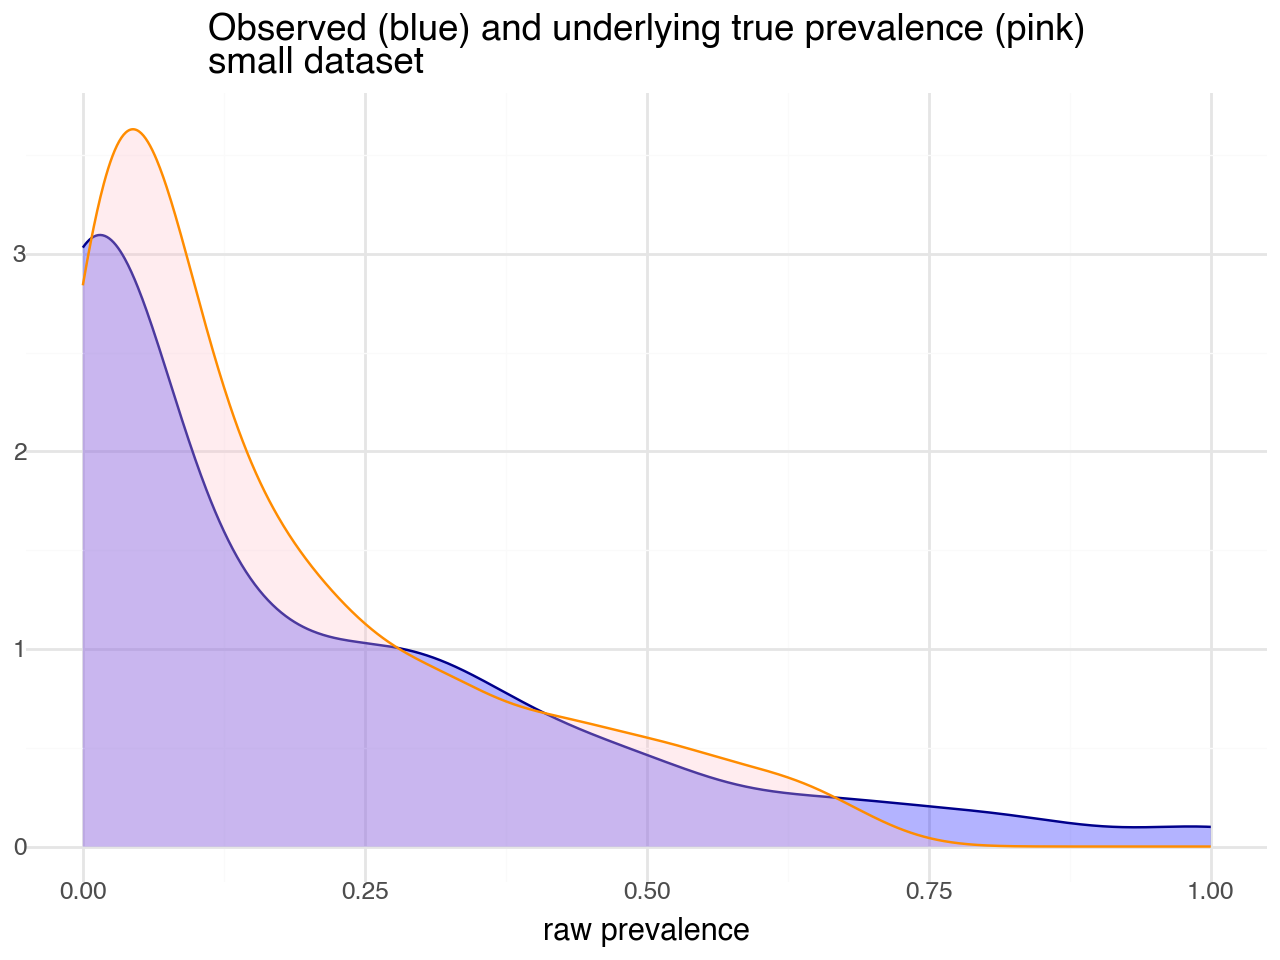

In [7]:
sim_df = pd.DataFrame({'tests':sim_data.tests[0], 'pos_tests':sim_data.pos_tests[0], 'p_sample':sim_data.p_sample[0]})
sim_df['raw_prev'] = sim_df['pos_tests'] / sim_df['tests']
(
    p9.ggplot(sim_df)
    + p9.geom_density(p9.aes(x='raw_prev'), color='darkblue', fill='blue', alpha=0.3)
    + p9.geom_density(p9.aes(x='p_sample'), color='darkorange', fill='pink', alpha=0.3)
    + p9.labs(
        x='raw prevalence',
        y='',
        title='Observed (blue) and underlying true prevalence (pink)\nsmall dataset'
    )
    + p9.theme_minimal()
)

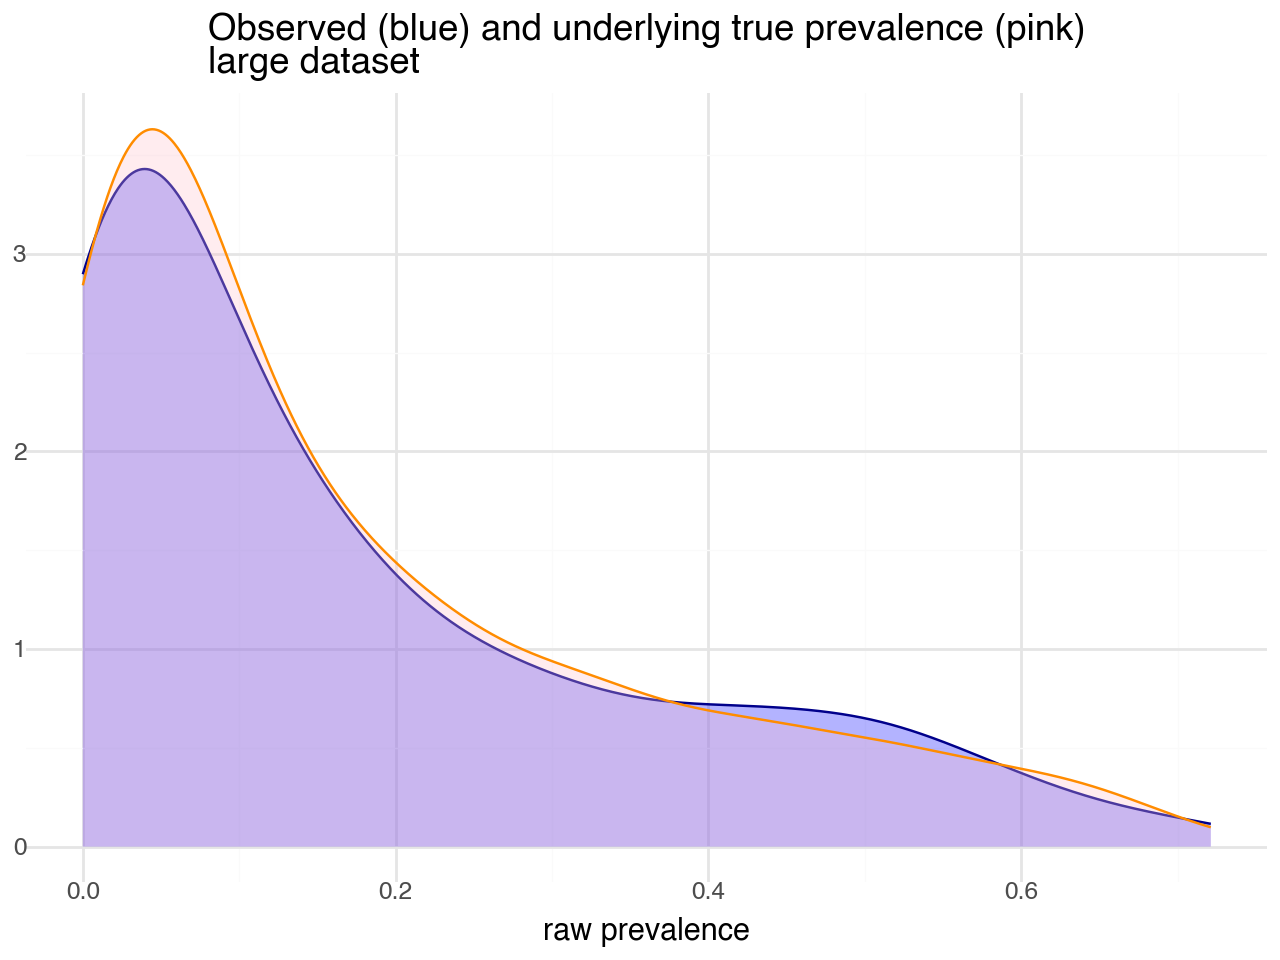

In [8]:
sim_df = pd.DataFrame({'tests':sim_data_lg.tests[0], 'pos_tests':sim_data_lg.pos_tests[0], 'p_sample':sim_data_lg.p_sample[0]})
sim_df['raw_prev'] = sim_df['pos_tests'] / sim_df['tests']
(
    p9.ggplot(sim_df)
    + p9.geom_density(p9.aes(x='raw_prev'), color='darkblue', fill='blue', alpha=0.3)
    + p9.geom_density(p9.aes(x='p_sample'), color='darkorange', fill='pink', alpha=0.3)
    + p9.labs(
        x='raw prevalence',
        y='',
        title='Observed (blue) and underlying true prevalence (pink)\nlarge dataset'
    )
    + p9.theme_minimal()
)

### Model Fitting

Assemble the data dictionary of all input data for the model which solves the inverse problem -
i.e., estimates regression coefficients given the observed data.
We use the generated data as the inputs.
Because the output files are real-valued outputs, regardless of variable element type,
model data variables of type int need to be cast to int.
Here all the observed data is count and categorial data.

In [9]:
data_fixed = {'N':sim_data.pos_tests.shape[1], 
              'N_age':gen_data_dict['N_age'], 
              'N_eth':gen_data_dict['N_eth'],
              'N_edu':gen_data_dict['N_edu'],
              'sens': gen_data_dict['sens'],
              'spec': gen_data_dict['spec'],
              'intercept_prior_mean': gen_data_dict['baseline'],
              'intercept_prior_scale': 2.5}

data_small = data_fixed | {'pos_tests':sim_data.pos_tests[0].astype(int),
             'tests':sim_data.tests[0].astype(int),
             'sex':sim_data.sex[0].astype(int),
             'age':sim_data.age[0].astype(int), 
             'eth':sim_data.eth[0].astype(int),
             'edu':sim_data.edu[0].astype(int)}

data_large = data_fixed | {'pos_tests':sim_data_lg.pos_tests[0].astype(int),
             'tests':sim_data_lg.tests[0].astype(int),
             'sex':sim_data_lg.sex[0].astype(int),
             'age':sim_data_lg.age[0].astype(int), 
             'eth':sim_data_lg.eth[0].astype(int),
             'edu':sim_data_lg.edu[0].astype(int)}

Record the data-generating parameters

In [10]:
true_params = {
    'beta_0': sim_data.beta_0[0],
    'pct_sex': sim_data.pct_sex[0],
    'beta_sex': sim_data.beta_sex[0],
    'pct_age': sim_data.pct_age[0],
    'beta_age':sim_data.beta_age[0],
    'pct_eth': sim_data.pct_eth[0],
    'beta_eth':sim_data.beta_eth[0],
    'pct_edu': sim_data.pct_edu[0],
    'beta_edu':sim_data.beta_edu[0]
}
true_params

{'beta_0': -3.5,
 'pct_sex': array([0.4, 0.6]),
 'beta_sex': 0.591981,
 'pct_age': array([0.11, 0.02, 0.1 , 0.15, 0.04, 0.14, 0.25, 0.12, 0.08]),
 'beta_age': array([-0.74, -1.43, -1.67,  1.  , -0.52, -0.77,  0.96,  1.31,  0.25]),
 'pct_eth': array([0.13, 0.64, 0.22]),
 'beta_eth': array([ 1.97, -0.8 ,  0.75]),
 'pct_edu': array([0.19, 0.24, 0.27, 0.09, 0.2 ]),
 'beta_edu': array([ 0.24, -0.22,  0.87, -0.85,  1.5 ])}

#### Model 1: `sum_to_zero_vector`

In [11]:
binomial_ozs_mod = CmdStanModel(stan_file=os.path.join('stan', 'binomial_4preds_ozs.stan'))

In [12]:
binomial_ozs_fit = binomial_ozs_mod.sample(data=data_small, parallel_chains=4)

21:04:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:04:44 - cmdstanpy - INFO - CmdStan done processing.
21:04:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'binomial_4preds_ozs.stan', line 55, column 2 to column 42)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'binomial_4preds_ozs.stan', line 55, column 2 to column 42)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'binomial_4preds_ozs.stan', line 57, column 2 to column 42)
Consider re-running with show_console=True if the above output is unclear!


Record the seed used for the first run and use it for all subsequent fits.

In [13]:
a_seed = binomial_ozs_fit.metadata.cmdstan_config['seed']

In [14]:
binomial_ozs_fit_lg = binomial_ozs_mod.sample(data=data_large, parallel_chains=4, seed=a_seed)

21:04:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:04:45 - cmdstanpy - INFO - CmdStan done processing.
21:04:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'binomial_4preds_ozs.stan', line 55, column 2 to column 42)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'binomial_4preds_ozs.stan', line 57, column 2 to column 42)
Consider re-running with show_console=True if the above output is unclear!


#### Model 2:  Hard sum-to-zero constraint

Run the sampler to get posterior estimates of the model conditioned on the data. 

In [15]:
binomial_hard_mod = CmdStanModel(stan_file=os.path.join('stan', 'binomial_4preds_hard.stan'))

In [16]:
binomial_hard_fit = binomial_hard_mod.sample(data=data_small, parallel_chains=4, seed=a_seed)

21:04:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:04:46 - cmdstanpy - INFO - CmdStan done processing.
21:04:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'binomial_4preds_hard.stan', line 44, column 2 to column 38)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'binomial_4preds_hard.stan', line 44, column 2 to column 38)
Consider re-running with show_console=True if the above output is unclear!


In [17]:
binomial_hard_fit_lg = binomial_hard_mod.sample(data=data_large, parallel_chains=4, seed=a_seed)

21:04:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:04:47 - cmdstanpy - INFO - CmdStan done processing.
21:04:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'binomial_4preds_hard.stan', line 44, column 2 to column 38)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'binomial_4preds_hard.stan', line 44, column 2 to column 38)
Consider re-running with show_console=True if the above output is unclear!


#### Model 3:  soft sum-to-zero constraint

In [18]:
binomial_soft_mod = CmdStanModel(stan_file=os.path.join('stan', 'binomial_4preds_soft.stan'))

In [19]:
binomial_soft_fit = binomial_soft_mod.sample(data=data_small, parallel_chains=4, seed=a_seed)

21:04:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:05:00 - cmdstanpy - INFO - CmdStan done processing.
21:05:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'binomial_4preds_soft.stan', line 44, column 2 to column 34)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'binomial_4preds_soft.stan', line 44, column 2 to column 34)
Consider re-running with show_console=True if the above output is unclear!


In [20]:
binomial_soft_fit_lg = binomial_soft_mod.sample(data=data_large, parallel_chains=4, seed=a_seed)

21:05:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:05:04 - cmdstanpy - INFO - CmdStan done processing.
21:05:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'binomial_4preds_soft.stan', line 44, column 2 to column 34)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'binomial_4preds_soft.stan', line 44, column 2 to column 34)
Consider re-running with show_console=True if the above output is unclear!


#### Runtime performance

In the small data regime, the soft-sum to zero takes considerably more wall-clock time to fit the data.
On Apple M3 hardware, all three models quickly fit the large dataset.


### Model Checking and Comparison

#### Check convergence

We check the R-hat and effective sample size (ESS) for all group-level parameters.

In [21]:
# small dataset
ozs_fit_summary = binomial_ozs_fit.summary(sig_figs=2)
ozs_fit_summary.index =  ozs_fit_summary.index.astype(str) + "  a) ozs"

hard_fit_summary = binomial_hard_fit.summary(sig_figs=2)
hard_fit_summary.index = hard_fit_summary.index.astype(str) + "  b) hard"

soft_fit_summary = binomial_soft_fit.summary(sig_figs=2)
soft_fit_summary.index = soft_fit_summary.index.astype(str) + "  c) soft"

small_data_fits_summary = pd.concat([ozs_fit_summary, hard_fit_summary, soft_fit_summary])

# large dataset
ozs_fit_lg_summary = binomial_ozs_fit_lg.summary(sig_figs=2)
ozs_fit_lg_summary.index =  ozs_fit_lg_summary.index.astype(str) + "  a) ozs"

hard_fit_lg_summary = binomial_hard_fit_lg.summary(sig_figs=2)
hard_fit_lg_summary.index = hard_fit_lg_summary.index.astype(str) + "  b) hard"

soft_fit_lg_summary = binomial_soft_fit_lg.summary(sig_figs=2)
soft_fit_lg_summary.index = soft_fit_lg_summary.index.astype(str) + "  c) soft"

large_data_fits_summary = pd.concat([ozs_fit_lg_summary, hard_fit_lg_summary, soft_fit_lg_summary])

summary_cols = ['Mean', 'StdDev', 'ESS_bulk', 'ESS_tail', 'R_hat']

**Eth**

In [22]:
beta_eth_summary = summarize_predictor(small_data_fits_summary, 'beta_eth\[')
beta_eth_summary_lg = summarize_predictor(large_data_fits_summary, 'beta_eth\[')

In [23]:
small_html = style_dataframe(beta_eth_summary).to_html()
large_html = style_dataframe(beta_eth_summary_lg).to_html()
display_side_by_side(small_html, large_html)

,Mean,StdDev,ESS_bulk,ESS_tail,R_hat
beta_eth[1] a) ozs,1.40,0.10,3500.00,3000.00,1.00
beta_eth[1] b) hard,1.40,0.10,3400.00,3300.00,1.00
beta_eth[1] c) soft,1.40,0.10,2700.00,2700.00,1.00
beta_eth[2] a) ozs,-1.50,0.08,3800.00,3600.00,1.00
beta_eth[2] b) hard,-1.50,0.08,3200.00,3000.00,1.00
beta_eth[2] c) soft,-1.50,0.08,3000.00,3100.00,1.00
beta_eth[3] a) ozs,0.10,0.08,4600.00,3200.00,1.00
beta_eth[3] b) hard,0.10,0.09,9900.00,2700.00,1.00
beta_eth[3] c) soft,0.10,0.08,3600.00,2800.00,1.00
,Mean,StdDev,ESS_bulk,ESS_tail,R_hat


In [24]:
print("params", true_params['beta_eth'], "\npcts", true_params['pct_eth'])

params [ 1.97 -0.8   0.75] 
pcts [0.13 0.64 0.22]


In [25]:
sigma_eth_summary = summarize_predictor(small_data_fits_summary, 'sigma_eth')
sigma_eth_summary_lg = summarize_predictor(large_data_fits_summary, 'sigma_eth')

small_html = style_dataframe(sigma_eth_summary).to_html()
large_html = style_dataframe(sigma_eth_summary_lg).to_html()
display_side_by_side(small_html, large_html)

,Mean,StdDev,ESS_bulk,ESS_tail,R_hat
sigma_eth a) ozs,1.10,0.38,4700.00,2900.00,1.00
sigma_eth b) hard,1.40,0.45,5200.00,3400.00,1.00
sigma_eth c) soft,1.20,0.40,4000.00,3000.00,1.00
,Mean,StdDev,ESS_bulk,ESS_tail,R_hat
sigma_eth a) ozs,1.00,0.37,4700.00,2700.00,1.00
sigma_eth b) hard,1.30,0.44,5500.00,3300.00,1.00
sigma_eth c) soft,1.20,0.40,5700.00,3000.00,1.00


**Edu**

In [26]:
beta_edu_summary = summarize_predictor(small_data_fits_summary, 'beta_edu\[')
beta_edu_summary_lg = summarize_predictor(large_data_fits_summary, 'beta_edu\[')

In [27]:
small_html = style_dataframe(beta_edu_summary).to_html()
large_html = style_dataframe(beta_edu_summary_lg).to_html()
display_side_by_side(small_html, large_html)

,Mean,StdDev,ESS_bulk,ESS_tail,R_hat
beta_edu[1] a) ozs,-0.18,0.12,4700.00,3100.00,1.00
beta_edu[1] b) hard,-0.19,0.12,4000.00,3200.00,1.00
beta_edu[1] c) soft,-0.18,0.12,3400.00,2800.00,1.00
beta_edu[2] a) ozs,-0.36,0.12,5100.00,2600.00,1.00
beta_edu[2] b) hard,-0.37,0.12,4000.00,2900.00,1.00
beta_edu[2] c) soft,-0.36,0.12,4100.00,2700.00,1.00
beta_edu[3] a) ozs,0.63,0.10,4100.00,3000.00,1.00
beta_edu[3] b) hard,0.62,0.10,3400.00,3100.00,1.00
beta_edu[3] c) soft,0.63,0.10,3400.00,2600.00,1.00
beta_edu[4] a) ozs,-1.20,0.22,3300.00,3100.00,1.00


In [28]:
print("params", true_params['beta_edu'], "\npcts", true_params['pct_edu'])

params [ 0.24 -0.22  0.87 -0.85  1.5 ] 
pcts [0.19 0.24 0.27 0.09 0.2 ]


In [29]:
sigma_edu_summary = summarize_predictor(small_data_fits_summary, 'sigma_edu')
sigma_edu_summary_lg = summarize_predictor(large_data_fits_summary, 'sigma_edu')

small_html = style_dataframe(sigma_edu_summary).to_html()
large_html = style_dataframe(sigma_edu_summary_lg).to_html()
display_side_by_side(small_html, large_html)

,Mean,StdDev,ESS_bulk,ESS_tail,R_hat
sigma_edu a) ozs,0.84,0.29,4600.00,3300.00,1.00
sigma_edu b) hard,0.84,0.32,3900.00,3100.00,1.00
sigma_edu c) soft,0.90,0.29,3500.00,2900.00,1.00
,Mean,StdDev,ESS_bulk,ESS_tail,R_hat
sigma_edu a) ozs,0.88,0.28,4400.00,2700.00,1.00
sigma_edu b) hard,0.88,0.33,4800.00,2700.00,1.00
sigma_edu c) soft,0.96,0.30,6600.00,3100.00,1.00


**Age**

In [30]:
beta_age_summary = summarize_predictor(small_data_fits_summary, 'beta_age\[')
beta_age_summary_lg = summarize_predictor(large_data_fits_summary, 'beta_age\[')

In [31]:
small_html = style_dataframe(beta_age_summary).to_html()
large_html = style_dataframe(beta_age_summary_lg).to_html()
display_side_by_side(small_html, large_html)

,Mean,StdDev,ESS_bulk,ESS_tail,R_hat
beta_age[1] a) ozs,-0.78,0.20,6400.00,3000.00,1.00
beta_age[1] b) hard,-0.78,0.21,5100.00,3100.00,1.00
beta_age[1] c) soft,-0.78,0.20,3900.00,2800.00,1.00
beta_age[2] a) ozs,-1.10,0.54,1800.00,1900.00,1.00
beta_age[2] b) hard,-1.20,0.56,1500.00,1800.00,1.00
beta_age[2] c) soft,-1.10,0.54,1800.00,2100.00,1.00
beta_age[3] a) ozs,-1.30,0.25,6200.00,2900.00,1.00
beta_age[3] b) hard,-1.30,0.25,4100.00,3300.00,1.00
beta_age[3] c) soft,-1.30,0.25,3500.00,2900.00,1.00
beta_age[4] a) ozs,1.20,0.15,3000.00,2600.00,1.00


In [32]:
print("params", true_params['beta_age'], "\npcts", true_params['pct_age'])

params [-0.74 -1.43 -1.67  1.   -0.52 -0.77  0.96  1.31  0.25] 
pcts [0.11 0.02 0.1  0.15 0.04 0.14 0.25 0.12 0.08]


In [33]:
sigma_age_summary = summarize_predictor(small_data_fits_summary, 'sigma_age')
sigma_age_summary_lg = summarize_predictor(large_data_fits_summary, 'sigma_age')

small_html = style_dataframe(sigma_age_summary).to_html()
large_html = style_dataframe(sigma_age_summary_lg).to_html()
display_side_by_side(small_html, large_html)

,Mean,StdDev,ESS_bulk,ESS_tail,R_hat
sigma_age a) ozs,0.99,0.25,3400.00,3000.00,1.00
sigma_age b) hard,1.10,0.28,3600.00,2900.00,1.00
sigma_age c) soft,1.00,0.26,3100.00,2100.00,1.00
,Mean,StdDev,ESS_bulk,ESS_tail,R_hat
sigma_age a) ozs,1.10,0.25,4600.00,2800.00,1.00
sigma_age b) hard,1.20,0.28,4700.00,2700.00,1.00
sigma_age c) soft,1.10,0.26,5300.00,2800.00,1.00


All models have R-hat values of 1.00 for all group-level parameters and high effective sample sizes.

Comparison with the true parameters shows that the model recovers the sign of the parameter, but not the exact value.
With more data and only a few categories, the model does a better job of recovering the true parameters.

In almost all cases, estimates for each parameter are the same across implementations to 2 significant figures.
In a few cases they are off by 0.01; where they are off, the percentage of observations for that parameter is correspondingly low.
This is as expected; all three implementations of the sum-to-zero constraint do the same thing;
the `sum_to_zero_vector` implementation is both fast and efficient.

#### Calibration check

All models contain a `generated quantities` block, which creates `y_rep`,
the [posterior predictive sample](https://mc-stan.org/docs/stan-users-guide/posterior-prediction.html).
If the model is well-calibrated for the data, 
we expect that at least 50% of the time the observed value of `y` will fall in the central 50% interval of the `y_rep` sample estimates.

In [34]:
from utils_dataviz import ppc_central_interval

y_rep_ozs = binomial_ozs_fit.y_rep.astype(int)
print("sum_to_zero_vector fit", ppc_central_interval(y_rep_ozs, sim_data.pos_tests[0]))

y_rep_hard = binomial_hard_fit.y_rep.astype(int)
print("Hard sum-to-zero fit", ppc_central_interval(y_rep_hard, sim_data.pos_tests[0]))

y_rep_soft = binomial_soft_fit.y_rep.astype(int)
print("Soft sum-to-zero fit", ppc_central_interval(y_rep_soft, sim_data.pos_tests[0]))

sum_to_zero_vector fit y total: 270, ct y is within y_rep central 50% interval: 223, pct: 82.59
Hard sum-to-zero fit y total: 270, ct y is within y_rep central 50% interval: 224, pct: 82.96
Soft sum-to-zero fit y total: 270, ct y is within y_rep central 50% interval: 225, pct: 83.33


### Visualize the fit

Plot the distribution of the actual data against the predicted data values for a random sample of replicates.
In file `utils_dataviz.py` we have implemented the equivalent of the R `bayesplot` package function
`ppc_dens_overlay`.

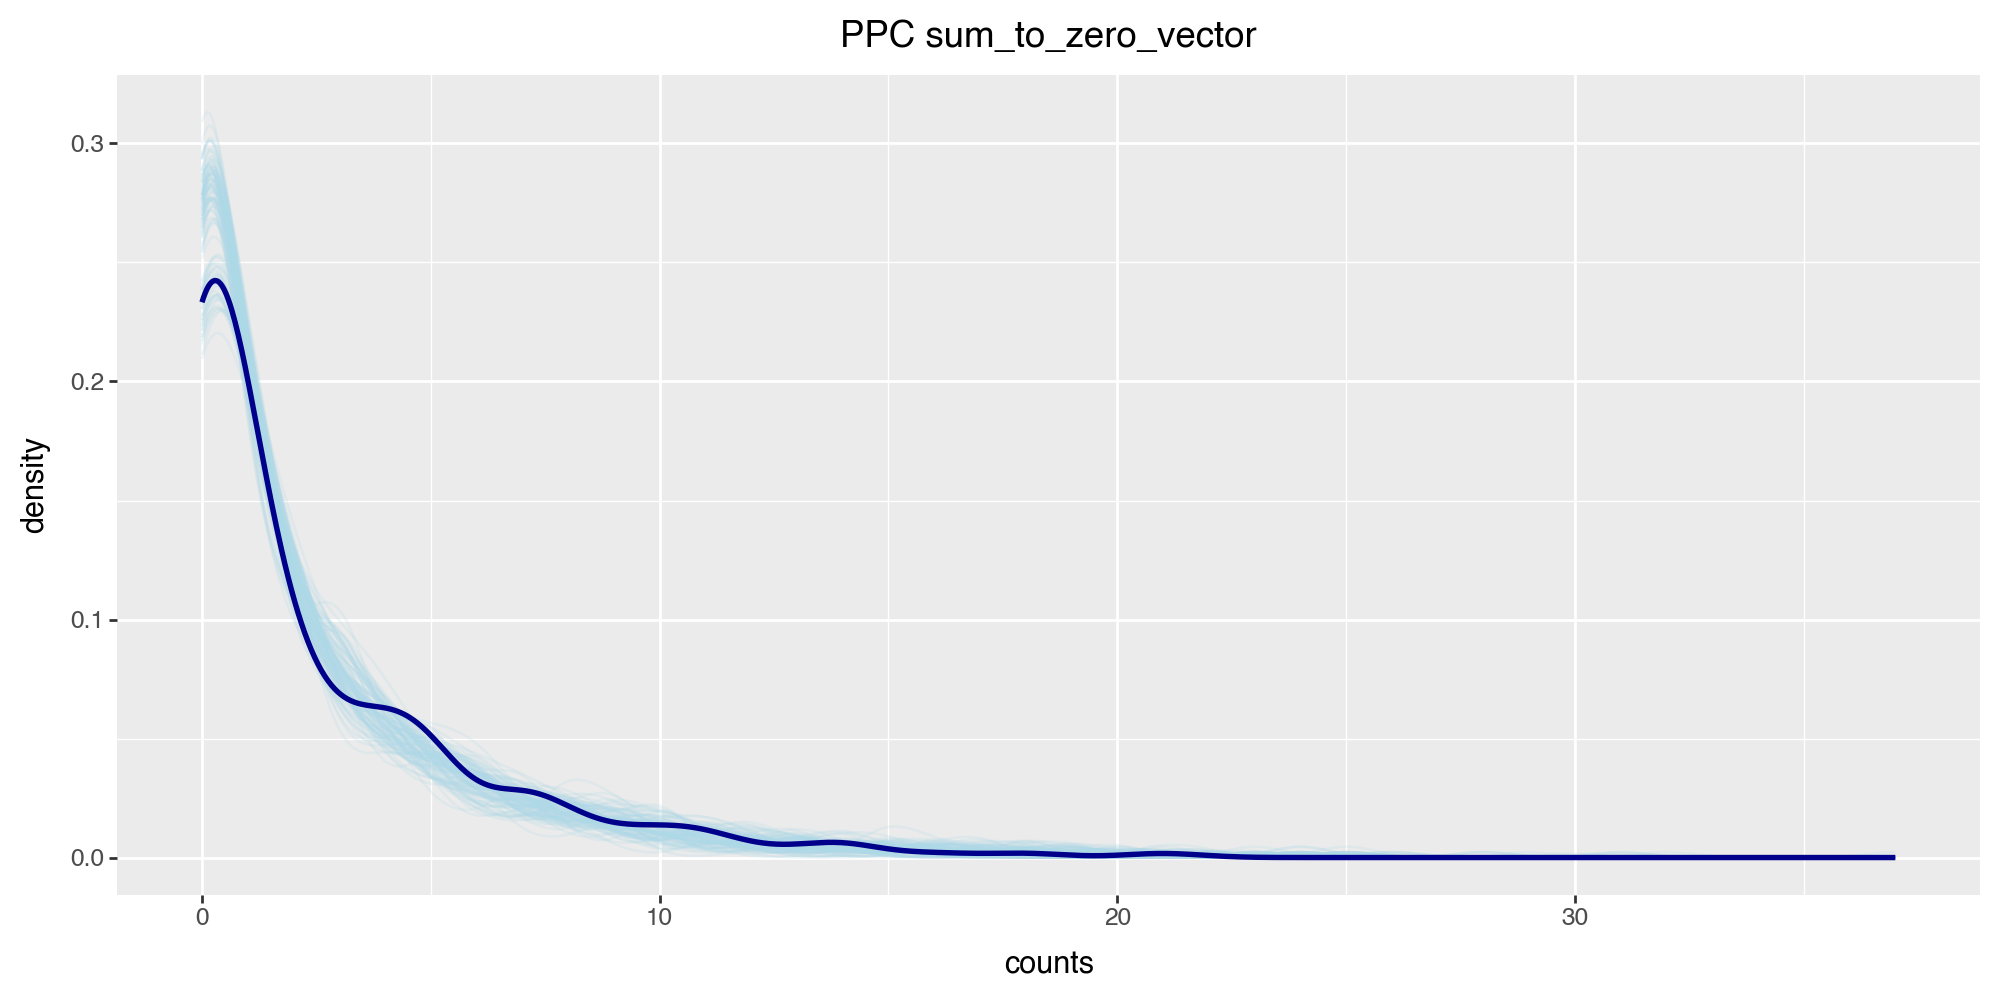

In [35]:
from utils_dataviz import ppc_dens_overlay
yrep_ozs = binomial_ozs_fit.stan_variable('y_rep')
ppc_plot_ozs = ppc_dens_overlay(sim_data.pos_tests[0].astype('int'), yrep_ozs, 100, 'PPC sum_to_zero_vector', 'counts')
ppc_plot_ozs

### Discussion

For the multi-level model, the `sum_to_zero_vector` provides the fastest wall-clock time
for both datasets.

## Spatial Models with an ICAR component

Spatial auto-correlation is the tendency for adjacent areas to share similar characteristics.
Conditional Auto-Regressive (CAR) and Intrinsic Conditional Auto-Regressive (ICAR) models,
first introduced by Besag, 1974, account for this by pooling information from neighboring regions.
The BYM model, (Besag, York, Mollié, 1991) extends a lognormal Poisson model
plus ICAR component for spatial auto-correlation by adding an ordinary
random-effects component for non-spatial heterogeneity.
The BYM2 model builds on this model and subsequent refinements.

These models are more fully explained in a series of notebooks
available from GitHub repo:  [https://github.com/mitzimorris/geomed_2024](https://github.com/mitzimorris/geomed_2024), see notebooks:
* [The ICAR model in Stan](https://github.com/mitzimorris/geomed_2024/blob/main/h4_icar.ipynb)
* [The BYM2 model in Stan](https://github.com/mitzimorris/geomed_2024/blob/main/h5_bym2.ipynb)
* [The BYM2_multicomp model in Stan](https://github.com/mitzimorris/geomed_2024/blob/main/h6_bym2_multicomp.ipynb)


### Example dataset:  New York City traffic accidents

The dataset we're using is that used in the analysis published in 2019
[Bayesian Hierarchical Spatial Models: Implementing the Besag York Mollié Model in Stan](https://www.sciencedirect.com/science/article/pii/S1877584518301175).

The data consists of motor vehicle collisions in New York City,
as recorded by the NYC Department of Transportation, between the years 2005-2014,
restricted to collisions involving school age children 5-18 years of age as pedestrians.
Each crash was localized to the US Census tract in which it occurred, using boundaries from the 2010 United States Census,
using the [2010 Census block map for New York City](https://data.cityofnewyork.us/City-Government/2010-Census-Blocks/v2h8-6mxf).  File `data/nyc_study.geojson` contains the study data and census tract ids and geometry.

In [36]:
nyc_geodata = gpd.read_file(os.path.join('data', 'nyc_study.geojson'))
nyc_geodata.columns
nyc_geodata[['BoroName', 'NTAName', 'count', 'kid_pop']].head(4)

,BoroName,NTAName,count,kid_pop
0,Bronx,Soundview-Castle Hill-Clason Point-Harding Park,9.00,894.00
1,Bronx,Soundview-Castle Hill-Clason Point-Harding Park,12.00,1158.00
2,Bronx,Soundview-Castle Hill-Clason Point-Harding Park,28.00,1120.00
3,Bronx,Mott Haven-Port Morris,14.00,281.00


The shapefiles from the Census Bureau connect Manhattan to Brooklyn and Queens, but for this analysis, Manhattan is quite separate from Brooklyn and Queens.  Getting the data assembled in the order required for our analysis requires data munging, encapsulated in the Python functions in file `utils_nyc_map.py`.
The function `nyc_sort_by_comp_size` removes any neighbor pairs between tracts in Manhattan and any tracts in Brooklyn or Queens and updates the neighbor graph accordingly.  It returns a clean neighbor graph and the corresponding geodataframe, plus a list of the component sizes.   The list is sorted so that the largest component (Brooklyn and Queens) is first, and singleton nodes are last.

In [37]:
from utils_nyc_map import nyc_sort_by_comp_size

(nyc_nbs, nyc_gdf, nyc_comp_sizes) = nyc_sort_by_comp_size(nyc_geodata)
nyc_comp_sizes

[1360, 329, 271, 108, 22, 2, 1, 1, 1]

To check our work we examine both the geodataframe and the map.

In [38]:
nyc_gdf[['BoroName', 'NTAName', 'count', 'kid_pop']].head(4)

,BoroName,NTAName,count,kid_pop
0,Brooklyn,East New York,6.00,432.00
1,Brooklyn,Flatbush,18.00,618.00
2,Brooklyn,Erasmus,15.00,891.00
3,Brooklyn,Flatbush,16.00,655.00


In [39]:
nyc_gdf[['BoroName', 'NTAName', 'count', 'kid_pop']].tail(4)

,BoroName,NTAName,count,kid_pop
2091,Manhattan,Lenox Hill-Roosevelt Island,1.00,1134.00
2092,Queens,Breezy Point-Belle Harbor-Rockaway Park-Broad ...,3.00,402.00
2093,Queens,Breezy Point-Belle Harbor-Rockaway Park-Broad ...,1.00,609.00
2094,Bronx,Pelham Bay-Country Club-City Island,6.00,565.00


(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

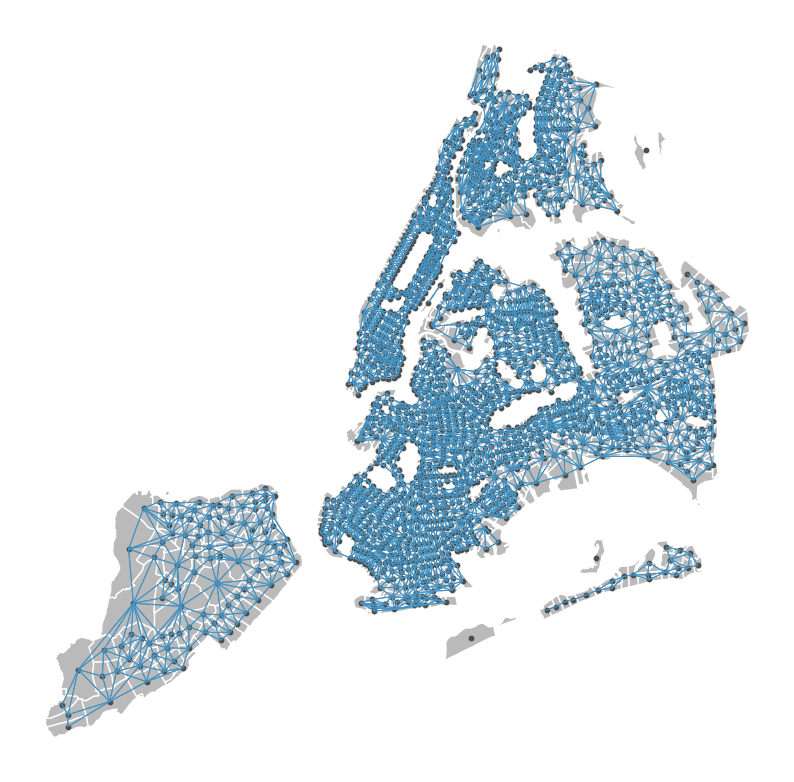

In [40]:
from splot.libpysal import plot_spatial_weights 
plot_spatial_weights(nyc_nbs, nyc_gdf)

### Model 1: The BYM2 model,  Riebler et al. 2016

The key element of the BYM2 model is the ICAR component.
Its conditional specification is a
multivariate normal random vector $\mathbf{\phi}$
where each ${\phi}_i$ is conditional on the values of its neighbors.

The joint specification rewrites to a _Pairwise Difference_,

$$ p(\phi) \propto \exp \left\{ {- \frac{1}{2}} \sum_{i \sim j}{({\phi}_i - {\phi}_j)}^2 \right\} $$

Each ${({\phi}_i - {\phi}_j)}^2$ contributes a
penalty term based on the distance between the values of neighboring regions.
However, $\phi$ is non-identifiable, constant added to $\phi$ washes out of ${\phi}_i - {\phi}_j$.
Therefore, a sum-to-zero constraint is needed to both identify and center $\phi$.

The Stan implementation of the ICAR component computes the sum of the pairwise distances
by representing the spatial adjacency matrix as a array of pairs of neighbor indices.

```stan
data {
  ...
  // spatial structure
  int<lower = 0> N_edges;  // number of neighbor pairs
  array[2, N_edges] int<lower = 1, upper = N> neighbors;  // columnwise adjacent
```

The ICAR prior comes into the model as parameter `phi`.
```stan
model {
  ...
  target += -0.5 * dot_self(phi[neighbors[1]] - phi[neighbors[2]]);  // ICAR prior
```

In this section, we compare three ways of implementing the sum-to-zero constraint on `phi`.

* In model `bym2_ozs.stan`, `phi` is declared as a `sum_to_zero_vector`.

* In model `bym2_ozs_hard.stan`, `phi_raw` is the unconstrained parameter of size `N - 1`,
and the N-length parameter `phi` is computed in the `transformed parameters` block.

* In model `bym2_soft.stan`, `phi` is declared as an ordinary vector,
and the sum-to-zero constraint is combined with the prior:

```stan
  target += (-0.5 * dot_self(phi[neighbors[1]] - phi[neighbors[2]])
	     + normal_lupdf(sum(phi) | 0, 0.001 * rows(phi)));
```

The ICAR model requires that the neighbor graph is fully connected for two reasons:

* The joint distribution is computed from the pairwise differences between a node and its neighbors;
singleton nodes have no neighbors and are therefore undefined.

* Even if the graph doesn't have any singleton nodes, when the graph has multiple connected components
a sum-to-zero constraint on the entire vector fails to properly identify the model.

Because the BYM2 model includes an ICAR component, it too requires a fully connected neighbor graph.
We can either artifically connect the map, or we can analyze the NYC dataset on a per-component basis,
starting with the largest component which encompasses Brooklyn and Queens (excepting the Rockaways).

number of components: 1
islands? []
max number of neighbors per node: 14
mean number of neighbors per node: 5.977941176470588


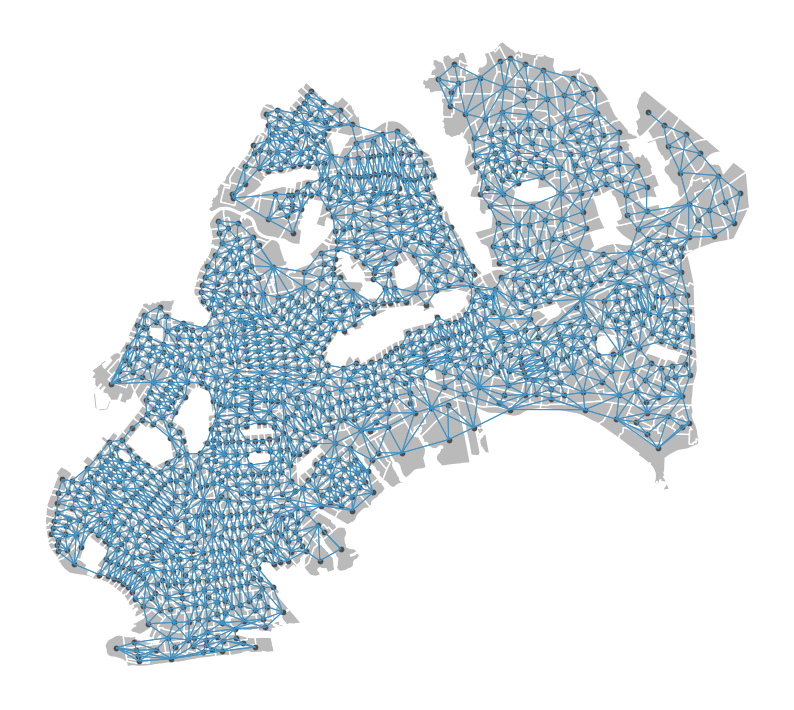

In [41]:
from libpysal.weights import Queen
brklyn_qns_gdf = nyc_gdf[nyc_gdf['comp_id']==0].reset_index(drop=True)
brklyn_qns_nbs = Queen.from_dataframe(brklyn_qns_gdf , geom_col='geometry')
plot_spatial_weights(brklyn_qns_nbs, brklyn_qns_gdf ) 

print(f'number of components: {brklyn_qns_nbs.n_components}')
print(f'islands? {brklyn_qns_nbs.islands}')
print(f'max number of neighbors per node: {brklyn_qns_nbs.max_neighbors}')
print(f'mean number of neighbors per node: {brklyn_qns_nbs.mean_neighbors}')

#### Data assembly

The inputs to the BYM2 model are

* The Poisson regression data

   + `int<lower=0> N` - number of regions
   + `array[N] int<lower=0> y` - per-region count outcome
   + `vector<lower=0>[N] E` - the population of each region (a.k.a. "exposure"),
   + `int<lower=1> K` - the number of predictors
   + `matrix[N, K] xs` - the design matrix

* The spatial structure

  + `int<lower = 0> N_edges` - the number of neighbor pairs
  + `array[2, N_edges] int<lower = 1, upper = N> neighbors` - the graph structure
  + `real tau` - the scaling factor, introduced in the BYM2

The scaling factor `tau` was introduced by Reibler et al so that the
variance of the spatial and ordinary random effects are both approximately equal to 1,
thus allowing for a straightforward estimate of the amount of spatial and non-spatial variance.
We have written a helper function called `get_scaling_factor`, in file `utils_bym2.py`
which takes as its argument the neighbor graph and computes the geometric mean of the
corresponding adjacency matrix.

In [42]:
from utils_bym2 import get_scaling_factor, nbs_to_adjlist

# design matrix
design_vars = np.array(['pct_pubtransit','med_hh_inc', 'traffic', 'frag_index'])
design_mat = brklyn_qns_gdf[design_vars].to_numpy()
design_mat[:, 1] = np.log(design_mat[:, 1])
design_mat[:, 2] = np.log(design_mat[:, 2])

# neighbors array
brklyn_qns_nbs_adj = nbs_to_adjlist(brklyn_qns_nbs)

# scaling factor
tau = get_scaling_factor(brklyn_qns_nbs)

brklyn_qns_data = {"N":brklyn_qns_gdf.shape[0],
            "y":brklyn_qns_gdf['count'].astype('int'),
            "E":brklyn_qns_gdf['kid_pop'].astype('int'),
            "K":4,
            "xs":design_mat,
            "N_edges": brklyn_qns_nbs_adj.shape[1],
            "neighbors": brklyn_qns_nbs_adj,
            "tau": tau
}

#### Model fitting

These models require larger numbers of warmup iterations in order to reach convergence for all parameters,
including hyperparameters `rho` and `sigma`.

In [43]:
bym2_ozs_mod = CmdStanModel(stan_file=os.path.join('stan', 'bym2_ozs.stan'))
brklyn_qns_ozs_fit = bym2_ozs_mod.sample(data=brklyn_qns_data, iter_warmup=5000)

21:05:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:05:51 - cmdstanpy - INFO - CmdStan done processing.


In [44]:
a_seed = brklyn_qns_ozs_fit.metadata.cmdstan_config['seed']

In [45]:
bym2_soft_mod = CmdStanModel(stan_file=os.path.join('stan', 'bym2_soft.stan'))
brklyn_qns_soft_fit = bym2_soft_mod.sample(data=brklyn_qns_data, iter_warmup=5000, seed=a_seed)

21:05:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:06:37 - cmdstanpy - INFO - CmdStan done processing.


In [46]:
bym2_hard_mod = CmdStanModel(stan_file=os.path.join('stan', 'bym2_hard.stan'))
brklyn_qns_hard_fit = bym2_hard_mod.sample(data=brklyn_qns_data, iter_warmup=5000, seed=a_seed)

21:06:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:08:38 - cmdstanpy - INFO - CmdStan done processing.


#### Model Comparison

Get summaries and compare fits.

In [47]:
brklyn_qns_ozs_summary = brklyn_qns_ozs_fit.summary()
brklyn_qns_soft_summary = brklyn_qns_soft_fit.summary()
brklyn_qns_hard_summary = brklyn_qns_hard_fit.summary()

brklyn_qns_ozs_summary.index =  brklyn_qns_ozs_summary.index.astype(str) + "  a) ozs"
brklyn_qns_hard_summary.index = brklyn_qns_hard_summary.index.astype(str) + "  b) hard"
brklyn_qns_soft_summary.index = brklyn_qns_soft_summary.index.astype(str) + "  c) soft"

brklyn_qns_fits_summary = pd.concat([brklyn_qns_ozs_summary, brklyn_qns_hard_summary, brklyn_qns_soft_summary])

In [48]:
beta_summary = summarize_predictor(brklyn_qns_fits_summary, 'beta')
sigma_summary = summarize_predictor(brklyn_qns_fits_summary, 'sigma')
rho_summary = summarize_predictor(brklyn_qns_fits_summary, 'rho')

brklyn_qns_summary = pd.concat([beta_summary, sigma_summary, rho_summary])

In [49]:
display(HTML(style_dataframe(brklyn_qns_summary).to_html()))

,Mean,StdDev,ESS_bulk,ESS_tail,R_hat
beta0 a) ozs,-4.45,0.02,1922.00,2647.03,1.00
beta0 b) hard,-4.45,0.02,1457.58,2400.72,1.00
beta0 c) soft,-4.45,0.02,2830.68,2787.66,1.00
beta_intercept a) ozs,-7.98,0.95,553.38,1230.07,1.00
beta_intercept b) hard,-8.01,0.95,466.96,1171.48,1.01
beta_intercept c) soft,-7.98,0.96,814.47,1779.00,1.00
betas[1] a) ozs,1.22,0.25,250.37,658.34,1.01
betas[1] b) hard,1.22,0.26,223.66,473.14,1.02
betas[1] c) soft,1.22,0.24,453.38,1123.93,1.01
betas[2] a) ozs,0.16,0.08,620.78,1496.79,1.01


Compare the fitted values of spatial component `phi`, which has a sum-to-zero constraint.

In [50]:
brklyn_qns_phi_ozs = brklyn_qns_ozs_fit.stan_variable('phi')
brklyn_qns_phi_soft = brklyn_qns_hard_fit.stan_variable('phi')
brklyn_qns_phi_hard = brklyn_qns_soft_fit.stan_variable('phi')

print('ozs: marginal mean estimates last elements phi',
	    np.mean(brklyn_qns_phi_ozs, axis=0)[-7:])

print('hard: marginal mean estimates last elements phi',
	    np.mean(brklyn_qns_phi_hard, axis=0)[-7:])

print('soft: marginal mean estimates last elements phi',
	    np.mean(brklyn_qns_phi_soft, axis=0)[-7:])

brklyn_qns_vars_phi_ozs = np.var(brklyn_qns_phi_ozs, axis=0)
print('ozs: marginal variances last elements phi', brklyn_qns_vars_phi_ozs[-7:])

brklyn_qns_vars_phi_hard = np.var(brklyn_qns_phi_hard, axis=0)
print('hard: marginal variances last elements phi', brklyn_qns_vars_phi_hard[-7:])

brklyn_qns_vars_phi_soft = np.var(brklyn_qns_phi_soft, axis=0)
print('soft: marginal variances last elements phi', brklyn_qns_vars_phi_soft[-7:])

ozs: marginal mean estimates last elements phi [-0.97 -0.44 -0.84 -0.71 -0.67 -0.13 -1.37]
hard: marginal mean estimates last elements phi [-0.97 -0.44 -0.84 -0.69 -0.68 -0.11 -1.39]
soft: marginal mean estimates last elements phi [-0.98 -0.43 -0.84 -0.69 -0.68 -0.1  -1.34]
ozs: marginal variances last elements phi [0.43 0.32 0.33 0.32 0.27 0.25 0.47]
hard: marginal variances last elements phi [0.42 0.32 0.32 0.36 0.29 0.24 0.46]
soft: marginal variances last elements phi [0.43 0.33 0.33 0.35 0.27 0.24 0.49]


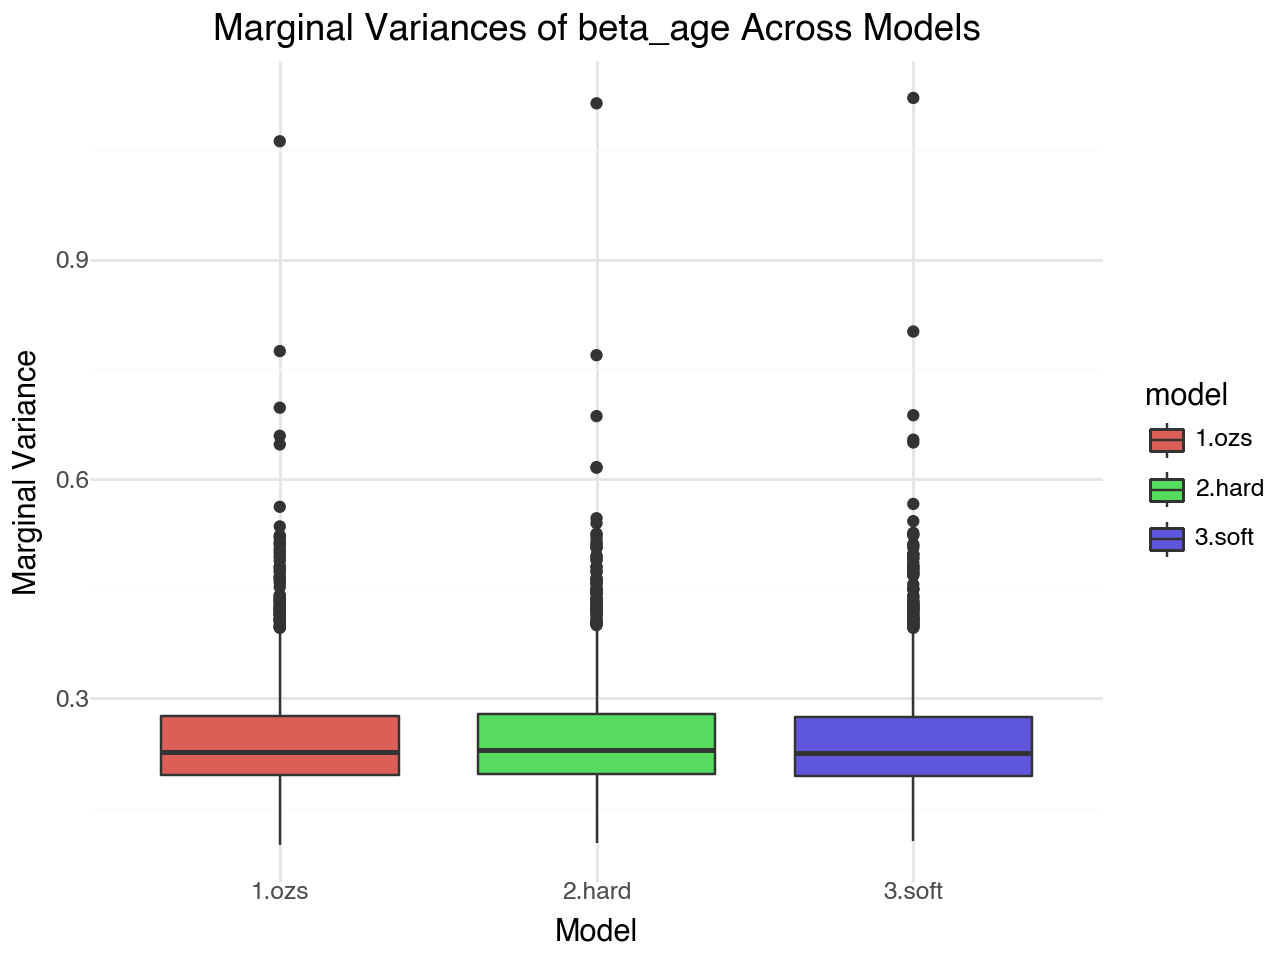

In [51]:
from utils_dataviz import marginal_variances_boxplot
boxplot = marginal_variances_boxplot(
    ["1.ozs", "2.hard", "3.soft"],
    [brklyn_qns_vars_phi_ozs, brklyn_qns_vars_phi_hard, brklyn_qns_vars_phi_soft]
)
boxplot

All implementations provide the approximately the same marginal variances.

We can repeat this procedure with the next largest component, the Bronx (excepting City Island).

number of regions: 329
number of components: 1
islands? []
max number of neighbors per node: 12
mean number of neighbors per node: 5.860182370820668


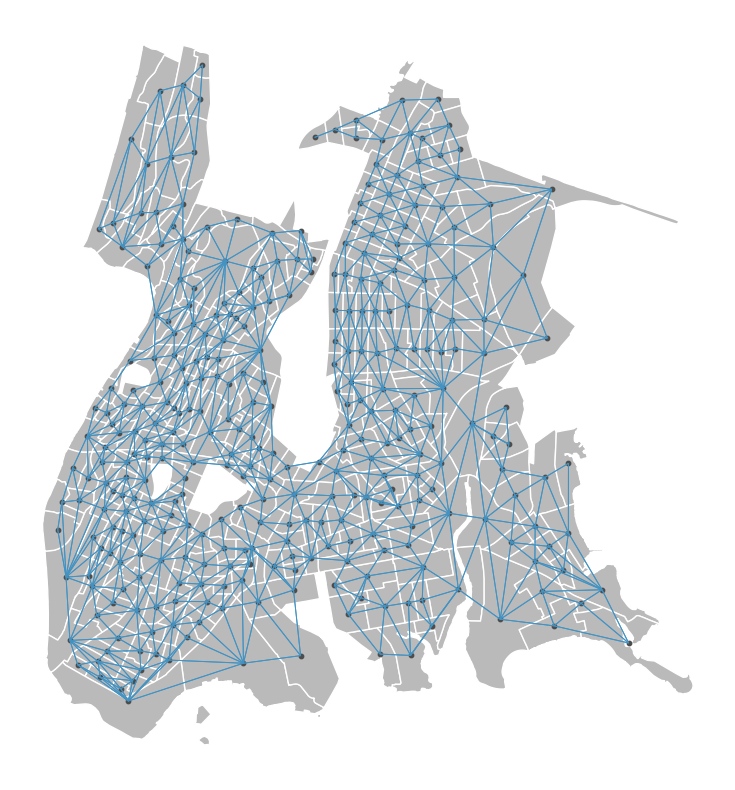

In [52]:
bronx_gdf = nyc_gdf[nyc_gdf['comp_id']==1].reset_index(drop=True)
print(f'number of regions: {bronx_gdf.shape[0]}')
bronx_nbs = Queen.from_dataframe(bronx_gdf , geom_col='geometry')
plot_spatial_weights(bronx_nbs, bronx_gdf ) 

print(f'number of components: {bronx_nbs.n_components}')
print(f'islands? {bronx_nbs.islands}')
print(f'max number of neighbors per node: {bronx_nbs.max_neighbors}')
print(f'mean number of neighbors per node: {bronx_nbs.mean_neighbors}')

In [53]:
# design matrix
design_vars = np.array(['pct_pubtransit','med_hh_inc', 'traffic', 'frag_index'])
design_mat = bronx_gdf[design_vars].to_numpy()
design_mat[:, 1] = np.log(design_mat[:, 1])
design_mat[:, 2] = np.log(design_mat[:, 2])

# neighbors array
bronx_nbs_adj = nbs_to_adjlist(bronx_nbs)

# scaling factor
tau = get_scaling_factor(bronx_nbs)

bronx_data = {"N":bronx_gdf.shape[0],
              "y":bronx_gdf['count'].astype('int'),
              "E":bronx_gdf['kid_pop'].astype('int'),
              "K":4,
              "xs":design_mat,
              "N_edges": bronx_nbs_adj.shape[1],
              "neighbors": bronx_nbs_adj,
              "tau": tau
}

In [54]:
bronx_ozs_fit = bym2_ozs_mod.sample(data=bronx_data, iter_warmup=5000)

21:09:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:09:31 - cmdstanpy - INFO - CmdStan done processing.


In [55]:
a_seed = bronx_ozs_fit.metadata.cmdstan_config['seed']

In [56]:
bronx_soft_fit = bym2_soft_mod.sample(data=bronx_data, iter_warmup=5000, seed=a_seed)

21:09:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:09:53 - cmdstanpy - INFO - CmdStan done processing.


In [57]:
bronx_hard_fit = bym2_hard_mod.sample(data=bronx_data, iter_warmup=5000, seed=a_seed)

21:09:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:10:20 - cmdstanpy - INFO - CmdStan done processing.
21:10:21 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 7 divergent transitions (0.7%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


In [58]:
bronx_ozs_summary = bronx_ozs_fit.summary()
bronx_soft_summary = bronx_soft_fit.summary()
bronx_hard_summary = bronx_hard_fit.summary()

bronx_ozs_summary.index =  bronx_ozs_summary.index.astype(str) + " 1.ozs"
bronx_hard_summary.index = bronx_hard_summary.index.astype(str) + " 2.hard"
bronx_soft_summary.index = bronx_soft_summary.index.astype(str) + " 3.soft"

bronx_fits_summary = pd.concat([bronx_ozs_summary, bronx_hard_summary, bronx_soft_summary])

In [59]:
beta_summary = summarize_predictor(bronx_fits_summary, 'beta')
sigma_summary = summarize_predictor(bronx_fits_summary, 'sigma')
rho_summary = summarize_predictor(bronx_fits_summary, 'rho')

bronx_summary = pd.concat([beta_summary, sigma_summary, rho_summary])

display(HTML(style_dataframe(bronx_summary).to_html()))

,Mean,StdDev,ESS_bulk,ESS_tail,R_hat
beta0 1.ozs,-4.45,0.04,2123.02,2710.05,1.00
beta0 2.hard,-4.45,0.04,1386.68,2051.69,1.00
beta0 3.soft,-4.45,0.04,1702.37,2211.68,1.00
beta_intercept 1.ozs,-4.66,1.89,961.17,1642.41,1.01
beta_intercept 2.hard,-4.59,1.93,504.25,1374.12,1.01
beta_intercept 3.soft,-4.69,1.93,729.10,1483.77,1.02
betas[1] 1.ozs,0.75,0.46,1290.70,2132.76,1.00
betas[1] 2.hard,0.75,0.46,700.15,1792.61,1.01
betas[1] 3.soft,0.74,0.46,792.60,1757.99,1.01
betas[2] 1.ozs,-0.10,0.16,752.79,1637.40,1.01


Compare the fitted values of spatial component `phi`, which has a sum-to-zero constraint.


ozs: marginal variances last elements phi [0.26 0.3  0.25 0.21 0.24]
hard: marginal variances last elements phi [0.26 0.3  0.27 0.22 0.24]
soft: marginal variances last elements phi [0.27 0.31 0.25 0.21 0.24]


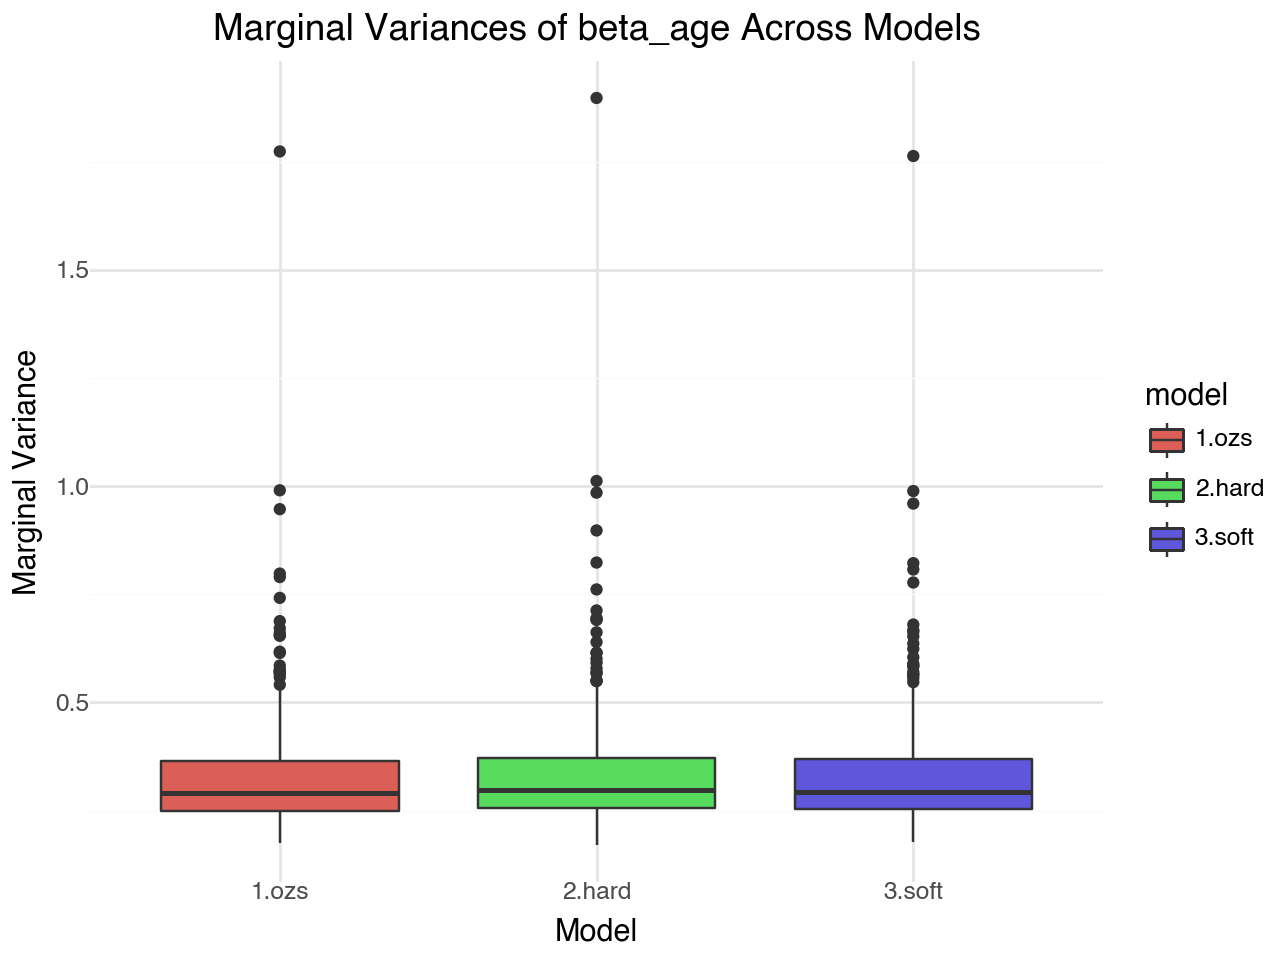

In [60]:
bronx_phi_ozs = bronx_ozs_fit.stan_variable('phi')
bronx_phi_soft = bronx_hard_fit.stan_variable('phi')
bronx_phi_hard = bronx_soft_fit.stan_variable('phi')

bronx_vars_phi_ozs = np.var(bronx_phi_ozs, axis=0)
print('ozs: marginal variances last elements phi', bronx_vars_phi_ozs[-5:])

bronx_vars_phi_hard = np.var(bronx_phi_hard, axis=0)
print('hard: marginal variances last elements phi', bronx_vars_phi_hard[-5:])

bronx_vars_phi_soft = np.var(bronx_phi_soft, axis=0)
print('soft: marginal variances last elements phi', bronx_vars_phi_soft[-5:])


boxplot = marginal_variances_boxplot(
    ["1.ozs", "2.hard", "3.soft"],
    [bronx_vars_phi_ozs, bronx_vars_phi_hard, bronx_vars_phi_soft]
)
boxplot

Next we skip to Staten Island.

number of regions: 108
number of components: 1
islands? []
max number of neighbors per node: 12
mean number of neighbors per node: 5.796296296296297


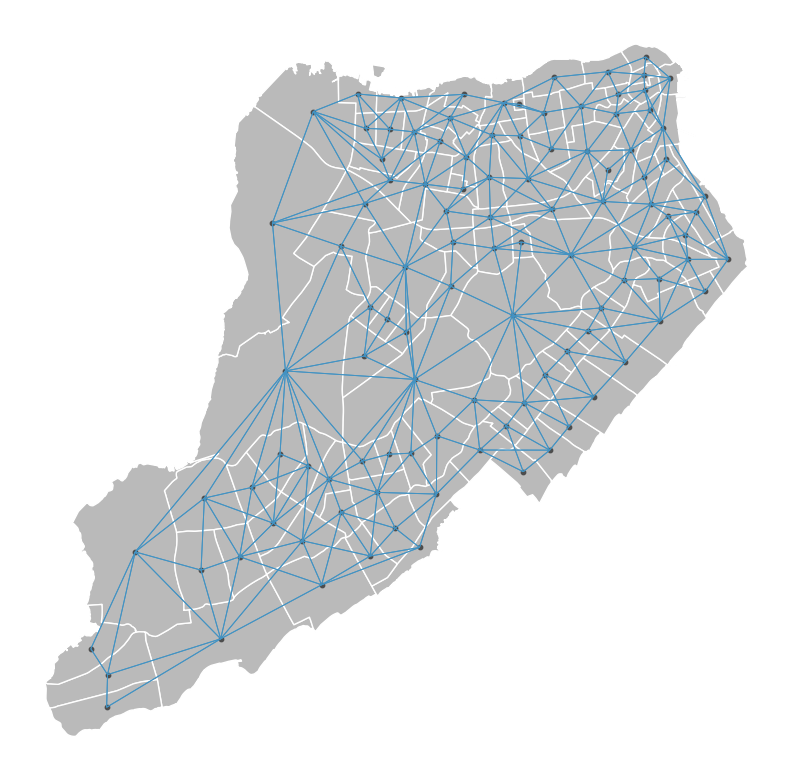

In [61]:
si_gdf = nyc_gdf[nyc_gdf['comp_id']==3].reset_index(drop=True)
print(f'number of regions: {si_gdf.shape[0]}')
si_nbs = Queen.from_dataframe(si_gdf , geom_col='geometry')
plot_spatial_weights(si_nbs, si_gdf ) 

print(f'number of components: {si_nbs.n_components}')
print(f'islands? {si_nbs.islands}')
print(f'max number of neighbors per node: {si_nbs.max_neighbors}')
print(f'mean number of neighbors per node: {si_nbs.mean_neighbors}')

In [62]:
# Data assembly

# design matrix
design_vars = np.array(['pct_pubtransit','med_hh_inc', 'traffic', 'frag_index'])
design_mat = si_gdf[design_vars].to_numpy()
design_mat[:, 1] = np.log(design_mat[:, 1])
design_mat[:, 2] = np.log(design_mat[:, 2])

# neighbors array
si_nbs_adj = nbs_to_adjlist(si_nbs)

# scaling factor
tau = get_scaling_factor(si_nbs)

si_data = {"N":si_gdf.shape[0],
              "y":si_gdf['count'].astype('int'),
              "E":si_gdf['kid_pop'].astype('int'),
              "K":4,
              "xs":design_mat,
              "N_edges": si_nbs_adj.shape[1],
              "neighbors": si_nbs_adj,
              "tau": tau
}

In [63]:
si_ozs_fit = bym2_ozs_mod.sample(data=si_data, iter_warmup=5000)

21:10:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:10:35 - cmdstanpy - INFO - CmdStan done processing.


In [64]:
a_seed = si_ozs_fit.metadata.cmdstan_config['seed']

In [65]:
si_soft_fit = bym2_soft_mod.sample(data=si_data, iter_warmup=5000, seed=a_seed)

21:10:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:10:44 - cmdstanpy - INFO - CmdStan done processing.


In [66]:
si_hard_fit = bym2_hard_mod.sample(data=si_data, iter_warmup=5000, seed=a_seed)

21:10:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:10:48 - cmdstanpy - INFO - CmdStan done processing.
21:10:48 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Chain 2 had 2 divergent transitions (0.2%)
	Chain 3 had 7 divergent transitions (0.7%)
	Chain 4 had 5 divergent transitions (0.5%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


In [67]:
si_ozs_summary = si_ozs_fit.summary()
si_soft_summary = si_soft_fit.summary()
si_hard_summary = si_hard_fit.summary()

si_ozs_summary.index =  si_ozs_summary.index.astype(str) + " 1.ozs"
si_hard_summary.index = si_hard_summary.index.astype(str) + " 2.hard"
si_soft_summary.index = si_soft_summary.index.astype(str) + " 3.soft"

si_fits_summary = pd.concat([si_ozs_summary, si_hard_summary, si_soft_summary])

In [68]:
beta_summary = summarize_predictor(si_fits_summary, 'beta')
sigma_summary = summarize_predictor(si_fits_summary, 'sigma')
rho_summary = summarize_predictor(si_fits_summary, 'rho')

si_summary = pd.concat([beta_summary, sigma_summary, rho_summary])

display(HTML(style_dataframe(si_summary).to_html()))

,Mean,StdDev,ESS_bulk,ESS_tail,R_hat
beta0 1.ozs,-4.91,0.07,2579.55,2675.49,1.00
beta0 2.hard,-4.91,0.06,4423.57,3026.81,1.00
beta0 3.soft,-4.90,0.07,2468.14,2419.34,1.00
beta_intercept 1.ozs,-6.36,3.40,2269.13,3017.67,1.00
beta_intercept 2.hard,-6.23,3.54,2958.09,3121.29,1.00
beta_intercept 3.soft,-6.21,3.44,1827.78,2475.91,1.00
betas[1] 1.ozs,0.10,0.72,3220.18,2660.04,1.00
betas[1] 2.hard,0.08,0.74,4088.25,2980.02,1.00
betas[1] 3.soft,0.10,0.72,2322.50,2654.39,1.00
betas[2] 1.ozs,0.06,0.31,1964.16,2671.09,1.00


Compare the fitted values of spatial component `phi`, which has a sum-to-zero constraint.


In [69]:
si_phi_ozs = si_ozs_fit.stan_variable('phi')
si_phi_soft = si_hard_fit.stan_variable('phi')
si_phi_hard = si_soft_fit.stan_variable('phi')

print('ozs: marginal mean estimates last elements phi',
	    np.mean(si_phi_ozs, axis=0)[-7:])

print('hard: marginal mean estimates last elements phi',
	    np.mean(si_phi_hard, axis=0)[-7:])

print('soft: marginal mean estimates last elements phi',
	    np.mean(si_phi_soft, axis=0)[-7:])

si_vars_phi_ozs = np.var(si_phi_ozs, axis=0)
print('ozs: marginal variances last elements phi', si_vars_phi_ozs[-7:])

si_vars_phi_hard = np.var(si_phi_hard, axis=0)
print('hard: marginal variances last elements phi', si_vars_phi_hard[-7:])

si_vars_phi_soft = np.var(si_phi_soft, axis=0)
print('soft: marginal variances last elements phi', si_vars_phi_soft[-7:])

ozs: marginal mean estimates last elements phi [-0.24  0.67  0.45  0.67  0.11  0.4  -1.2 ]
hard: marginal mean estimates last elements phi [-0.22  0.66  0.44  0.65  0.11  0.38 -1.2 ]
soft: marginal mean estimates last elements phi [-0.23  0.65  0.43  0.65  0.1   0.37 -1.19]
ozs: marginal variances last elements phi [0.23 0.17 0.17 0.22 0.15 0.23 0.24]
hard: marginal variances last elements phi [0.22 0.18 0.19 0.24 0.16 0.24 0.24]
soft: marginal variances last elements phi [0.21 0.17 0.17 0.22 0.15 0.23 0.23]


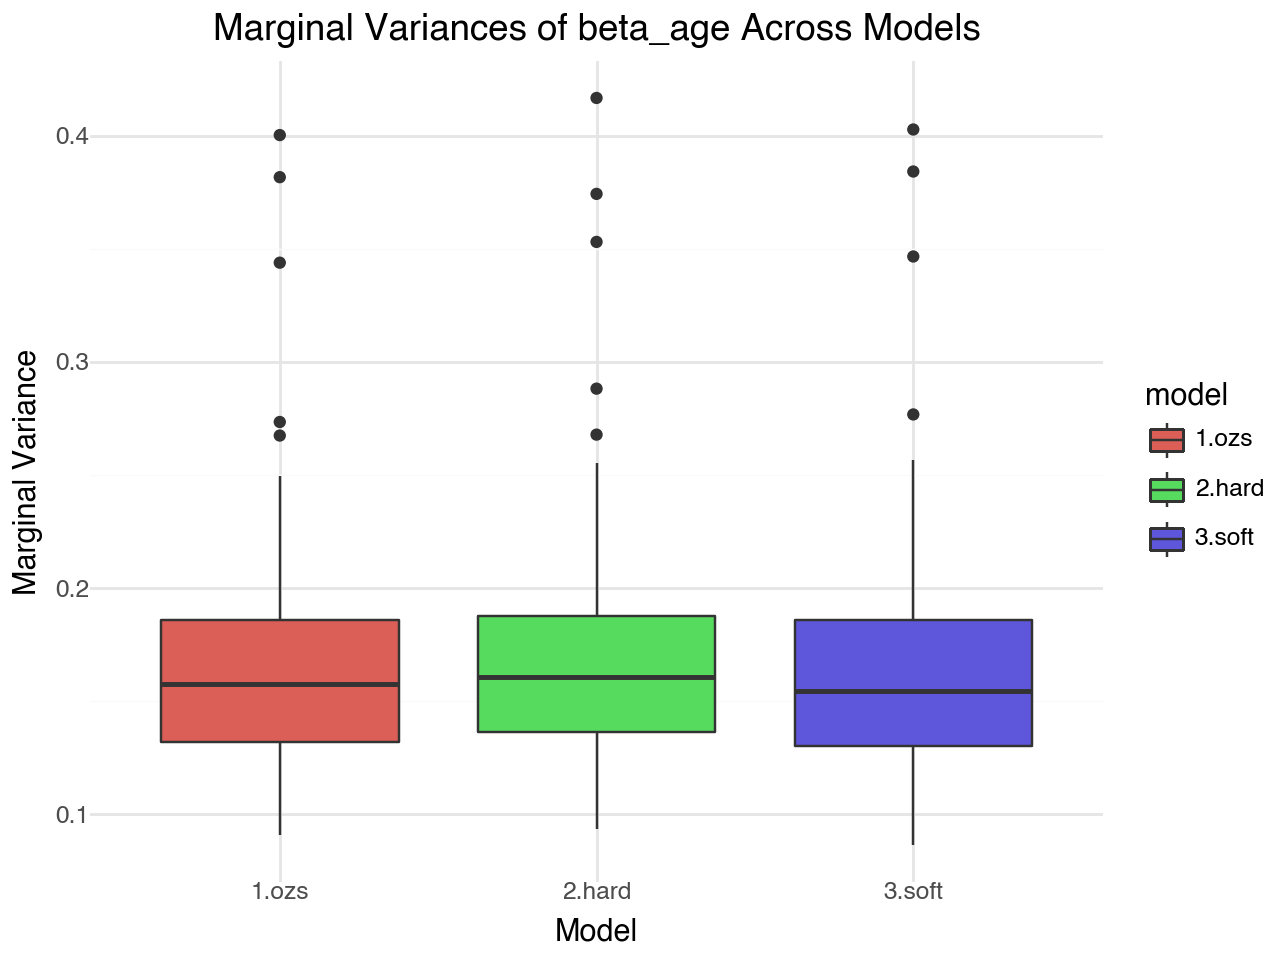

In [70]:
from utils_dataviz import marginal_variances_boxplot
boxplot = marginal_variances_boxplot(
    ["1.ozs", "2.hard", "3.soft"],
    [si_vars_phi_ozs, si_vars_phi_hard, si_vars_phi_soft]
)
boxplot

#### Discussion

All implementations return almost identical estimates.
The sum_to_zero_vector consistently has the fastest running time.
The hard sum-to-zero model produces higher effective sample sizes.
The marginal variances of the spatial component `phi` are roughly the same across all models;
presumably due to the fact that the ICAR prior is properly constraining the variances.

### Model 2: The BYM2_multicomp model, Freni-Sterrantino et al, 2018

In the previous section, we analyzed the New York City component-wise.
This is highly unsatisfactory.
In order to apply the BYM2 model to the full NYC dataset, it is necessary to
extend the BYM2 model to account for disconnected components and singleton nodes.

This has been done by Freni-Sterrantino et al. in 2018 for INLA, and presented in:
[A note on intrinsic Conditional Autoregressive models for disconnected graphs](https://arxiv.org/abs/1705.04854).
They provide the following recommendations:

* Non-singleton nodes are given the BYM2 prior
* Singleton nodes (islands) are given a standard Normal prior
* Compute per-connected component scaling factor
* **Impose a sum-to-zero constraint on each connected component**

We have followed these recommendations and implemented this model in Stan.
The full implementation details can be found in the notebook
* [The BYM2_multicomp model in Stan](https://github.com/mitzimorris/geomed_2024/blob/main/h6_bym2_multicomp.ipynb)

For this case study, we focus on how the BYM2_multicomp model implements the component-wise sum-to-zero constraint,
which requires operating on the elements of the spatial effects vector `phi` on a component-by-component basis.
By sorting the full NYC dataset by component, in order of component size, descending,
we can use Stan's [slicing with range indexes](https://mc-stan.org/docs/stan-users-guide/multi-indexing.html#slicing-with-range-indexes)

In the BYM2 model for a fully connected graph the sum-to-zero constraint on `phi`
is implemented directly by declaring `phi` to be a `sum_to_zero_vector`, which is a
[constrained parameter type](https://mc-stan.org/docs/reference-manual/transforms.html#variable-transforms.chapter).
The declaration:

```stan
  sum_to_zero_vector[N] phi;  // spatial effects
```

creates a *constrained* variable of length $N$, with a corresponding unconstrained variable of length $N-1$.

For the BYM2_multicomp model, we need to do declare the *unconstrained* parameter vector `phi_raw`
and the constraining transform, which is applied component-wise, to slices of `phi_raw`.
The number of connected components is $N\_components$, therefore the length of vector `phi_raw` is
$N - N\_components$.

```stan
  vector[N - N_components] phi_raw;  // spatial effects
```

In the `transformed parameters` block, we apply the constraining transform.

```stan
  vector[N_connected] phi = zero_sum_components_lp(phi_raw, component_idxs, component_sizes);
```

The constraining transform is defined in the program's `functions` block, via two functions:
the function `zero_sum_constrain_components_lp`, which handles the slicing,
and function `zero_sum_constrain_lp`, the actual constraining transform.

* `zero_sum_constrain_lp`: the constraining transform, following the `zero_sum_vector` implementation.

```stan
  /**
   * Constrain sum-to-zero vector
   *
   * @param y unconstrained zero-sum parameters
   * @return vector z, the vector whose slices sum to zero
   */
  vector zero_sum_constrain_lp(vector y) {
    int N = num_elements(y);
    vector[N + 1] z = zeros_vector(N + 1);
    real sum_w = 0;
    for (ii in 1:N) {
      int i = N - ii + 1; 
      real n = i;
      real w = y[i] * inv_sqrt(n * (n + 1));
      sum_w += w;
      z[i] += sum_w;     
      z[i + 1] -= w * n;    
    }
    return z;
  }
```

* `zero_sum_components_lp`: slices vector `phi` by component, applies constraining transform to each.

```stan
  /**
   * Component-wise constrain sum-to-zero vectors
   *
   * @param phi unconstrained vector of zero-sum slices
   * @param idxs component start and end indices
   * @param sizes component sizes
   * @return vector phi_ozs, the vector whose slices sum to zero
   */
  vector zero_sum_components_lp(vector phi,
                                array[ , ] int idxs,
                                array[] int sizes) {
    vector[sum(sizes)] phi_ozs;
    int idx_phi = 1;
    int idx_ozs = 1;
    for (i in 1:size(sizes)) {
      phi_ozs[idx_ozs : idx_ozs + sizes[i] - 1] =
        zero_sum_constrain_lp(segment(phi, idx_phi, sizes[i] - 1));
      idx_phi += sizes[i] - 1;
      idx_ozs += sizes[i];
    }
    return phi_ozs;
  }
```

#### Data Assembly

In [71]:
from utils_nyc_map import nyc_sort_by_comp_size

(nyc_nbs, nyc_gdf, nyc_comp_sizes) = nyc_sort_by_comp_size(nyc_geodata)
nyc_comp_sizes

[1360, 329, 271, 108, 22, 2, 1, 1, 1]

In [72]:
from utils_bym2 import get_multicomp_factors_sizes
# all data is in:   nyc_nbs, nyc_gdf, nyc_comp_sizes
component_sizes = [x for x in nyc_comp_sizes if x > 1]

# design matrix
design_vars = np.array(['pct_pubtransit','med_hh_inc', 'traffic', 'frag_index'])
design_mat = nyc_gdf[design_vars].to_numpy()
design_mat[:, 1] = np.log(design_mat[:, 1])
design_mat[:, 2] = np.log(design_mat[:, 2])

# neighbors array
nyc_nbs_adj = nbs_to_adjlist(nyc_nbs)

# scaling factor, sizes
(scaling_factors, edge_sizes) = get_multicomp_factors_sizes(len(component_sizes), nyc_gdf)

In [73]:
scaling_factors

array([0.71, 0.57, 0.8 , 0.36, 1.19, 0.25])

In [74]:
bym2_multicomp_data = {
    "N":nyc_gdf.shape[0],
    "y":nyc_gdf['count'].astype('int'),
    "E":nyc_gdf['kid_pop'].astype('int'),
    "K":4,
    "xs":design_mat,
    "N_edges": nyc_nbs_adj.shape[1],
    "neighbors": nyc_nbs_adj,
    "N_components": len(component_sizes),
    "component_sizes": component_sizes,
    "edgeset_sizes": edge_sizes,
    "scaling_factors": scaling_factors
}

#### Model Fitting

In [75]:
bym2_multicomp_ozs_file = os.path.join('stan', 'bym2_multicomp.stan')
bym2_multicomp_ozs_mod = CmdStanModel(stan_file=bym2_multicomp_ozs_file)

21:14:20 - cmdstanpy - INFO - compiling stan file /Users/mitzi/github/zmorris/sum_to_zero_vector/stan/bym2_multicomp.stan to exe file /Users/mitzi/github/zmorris/sum_to_zero_vector/stan/bym2_multicomp
21:14:25 - cmdstanpy - INFO - compiled model executable: /Users/mitzi/github/zmorris/sum_to_zero_vector/stan/bym2_multicomp
21:14:25 - cmdstanpy - WARNING - Stan compiler has produced 1 warnings:
21:14:25 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=bym2_multicomp.stan --o=/Users/mitzi/github/zmorris/sum_to_zero_vector/stan/bym2_multicomp.hpp /Users/mitzi/github/zmorris/sum_to_zero_vector/stan/bym2_multicomp.stan
Warning in 'bym2_multicomp.stan', line 104, column 28: Using _lp functions in
    transformed parameters is deprecated and will be disallowed in Stan 2.39.
    Use an _jacobian function instead, as this allows change of variable
    adjustments which are conditionally enabled by the algorithms.

--- Compiling C++ code ---
clang++

In [93]:
bym2_multicomp_ozs_fit = bym2_multicomp_ozs_mod.sample(data=bym2_multicomp_data, iter_warmup=5000)

21:46:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:47:26 - cmdstanpy - INFO - CmdStan done processing.


In [94]:
bym2_multicomp_ozs_summary = bym2_multicomp_ozs_fit.summary()

In [95]:
a_seed = bym2_multicomp_ozs_fit.metadata.cmdstan_config['seed']

In [82]:
bym2_multicomp_soft_file = os.path.join('stan', 'bym2_multicomp_soft.stan')
bym2_multicomp_soft_mod = CmdStanModel(stan_file=bym2_multicomp_soft_file)

21:18:41 - cmdstanpy - INFO - compiling stan file /Users/mitzi/github/zmorris/sum_to_zero_vector/stan/bym2_multicomp_soft.stan to exe file /Users/mitzi/github/zmorris/sum_to_zero_vector/stan/bym2_multicomp_soft
21:18:46 - cmdstanpy - INFO - compiled model executable: /Users/mitzi/github/zmorris/sum_to_zero_vector/stan/bym2_multicomp_soft


In [96]:
bym2_multicomp_soft_fit = bym2_multicomp_soft_mod.sample(data=bym2_multicomp_data, iter_warmup=3000, max_treedepth=15, seed=a_seed)

21:47:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

22:05:02 - cmdstanpy - INFO - CmdStan done processing.


In [97]:
bym2_multicomp_soft_summary = bym2_multicomp_soft_fit.summary()

In [99]:
bym2_multicomp_ozs_summary.index =  bym2_multicomp_ozs_summary.index.astype(str) + "  a) ozs"
bym2_multicomp_soft_summary.index =  bym2_multicomp_soft_summary.index.astype(str) + "  b) soft"
bym2_multicomp_summary = pd.concat([bym2_multicomp_ozs_summary, bym2_multicomp_soft_summary])

In [100]:
beta_summary = summarize_predictor(bym2_multicomp_summary, 'beta')
sigma_summary = summarize_predictor(bym2_multicomp_summary, 'sigma')
rho_summary = summarize_predictor(bym2_multicomp_summary, 'rho')
nyc_summary = pd.concat([beta_summary, sigma_summary, rho_summary])

In [101]:
nyc_summary

,Mean,StdDev,ESS_bulk,ESS_tail,R_hat
beta0 a) ozs,-4.48,0.02,1598.32,2216.77,1.00
beta0 b) soft,-4.48,0.02,1560.83,2375.17,1.00
beta_intercept a) ozs,-5.79,0.56,752.67,1572.12,1.00
beta_intercept b) soft,-5.77,0.57,730.92,1363.61,1.00
betas[1] a) ozs,0.81,0.17,587.04,1501.99,1.01
betas[1] b) soft,0.83,0.16,636.48,1420.99,1.01
betas[2] a) ozs,0.04,0.05,626.04,1255.23,1.01
betas[2] b) soft,0.04,0.05,509.21,1455.52,1.01
betas[3] a) ozs,0.03,0.02,1208.05,2283.87,1.00
betas[3] b) soft,0.03,0.02,1316.13,2206.31,1.00


## Conclusion: the `sum_to_zero_vector` just works!

For the multi-level regression model, the ICAR model and the BYM2 model,
the built-in `sum_to_zero_vector` returns the best effective sample size and
has the best wall-clock time as well.  This is most evident for the BYM2 model,
which has a relatively complex multilevel structure.
For the the multi-level regression model, the soft-sum-to-zero constraint struggles
when there is not much data.  Conversely, the hard-sum-to-zero constraint
struggles to fit the NYC dataset, where the sum-to-zero constraint is applied to
a relatively large vector.